In [1]:
# general purpose modules for handling data
import numpy as np
import pandas as pd

# for loading telo data column containing individual telomere length values
from ast import literal_eval

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mc

# custom module for handling telomere length data
import telomere_methods_astros as telo_ma

# statistics
import scipy.stats as stats
import scikit_posthocs as sp
from statsmodels.stats.anova import AnovaRM

# imputation
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# setting all graphs to have darkgrid style w/ black edges for axes elements
sns.set_style(style="darkgrid",rc={'patch.edgecolor': 'black'})

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hac

import importlib
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Analyzing Mean Telomere Lengths (FISH)
---

## Reading in telomere FISH data

In [681]:
astro_telos_per_cell_df = pd.read_csv('../data/compiled and processed data/exploded_cells_astros_df.csv')

astro_telofish_grouped = astro_telos_per_cell_df.groupby(by=['astro id', 'timepoint', 'flight status']).agg('mean').reset_index()

In [87]:
ctrl_telos_per_cell_df = pd.read_csv('../data/compiled and processed data/exploded_cells_ctrl_df.csv')

ctrl_telos_per_cell_df['flight status'] = 'Controls'
ctrl_telofish_grouped = ctrl_telos_per_cell_df.groupby(by=['control id', 'timepoint', 'flight status']).agg('mean').reset_index()

In [88]:
print(ctrl_telos_per_cell_df.shape)
for status in ['Pre-Flight', 'Mid-Flight', 'Post-Flight']:
    print(astro_telos_per_cell_df[astro_telos_per_cell_df['flight status'] == status].shape)
    
# print(ctrl_telofish_grouped.shape)
# for status in ['Pre-Flight', 'Mid-Flight', 'Post-Flight']:
#     print(astro_telofish_grouped[astro_telofish_grouped['flight status'] == status].shape)

(2010, 6)
(957, 6)
(180, 6)
(1206, 6)


## Mean Telomere Lengths for 11 Astros: Visualizations, Stats (Telo-FISH)

### Bar graph 

In [89]:
concat_astros_ctrl_per_cell = pd.concat([astro_telos_per_cell_df.assign(dataset='set1'),
                                         ctrl_telos_per_cell_df.assign(dataset='set2')], sort=False)

# concat_telofish_grouped = pd.concat([astro_telofish_grouped.assign(dataset='set1'),
#                                      ctrl_telofish_grouped.assign(dataset='set2')], sort=False)

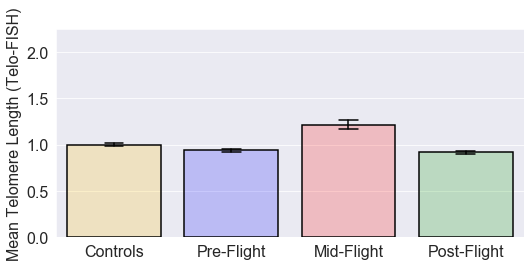

In [90]:
plt.figure(figsize=(8.4, 3.84))
fontsize=16

ax = sns.barplot(x='flight status', y='telo data per cell', data=concat_astros_ctrl_per_cell, 
                 order=['Controls', 'Pre-Flight', 'Mid-Flight', 'Post-Flight'],
                 alpha=None, capsize=0.16, linewidth=1.5, errwidth=1, **{'edgecolor':'black'},
                 ci=95, 
                )

# set alpha to None, enabling assignment of preferred colors to each bar while retaining alpha=1 on bar edges
for i, value in enumerate(['#FFC000', '#0000FF', '#FF0000', '#009900']):
    colors = mc.to_rgba(value)
    empty = (colors[0], colors[1], colors[2], 0.2)
    ax.patches[i].set_facecolor(empty)

plt.setp(ax.lines, color='black', linewidth=1.5)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Mean Telomere Length (Telo-FISH)', fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylim(0, 2.25)

plt.savefig('../MANUSCRIPT 11 ASTROS/figures/mean telomere length (Telo-FISH) 11 unrelated astronuats pre mid post.png', dpi=600)

In [91]:
telo_ma.telos_scipy_anova_post_hoc_tests(df0=concat_astros_ctrl_per_cell, time_col='flight status', 
                                         target='telo data per cell',
                                         sig_test=stats.f_oneway, post_hoc=None, repeated_measures=False)

ONE WAY ANOVA for telomere length: 2.4813332208156835e-41
   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower   upper  reject
-------------------------------------------------------
  Controls   Mid-Flight  0.211    0.1519   0.27   True 
  Controls  Post-Flight -0.0814   -0.109 -0.0537  True 
  Controls   Pre-Flight -0.0635  -0.0934 -0.0337  True 
 Mid-Flight Post-Flight -0.2924   -0.353 -0.2317  True 
 Mid-Flight  Pre-Flight -0.2745  -0.3362 -0.2128  True 
Post-Flight  Pre-Flight  0.0179   -0.015  0.0507 False 
-------------------------------------------------------
TukeyHSD pvalues: [0.001, 0.001, 0.001, 0.001, 0.001, 0.50130593191304]


### Lineplot 

### Grouping Telo-FISH data per astronaut/timepoint for lineplot

In [92]:
astro_telofish_grouped = (astro_telos_per_cell_df.groupby(by=['astro id', 'timepoint', 'flight status'])
                                                 .agg('mean').reset_index())

astro_telofish_grouped['timepoint'] = astro_telofish_grouped['timepoint'].apply(lambda row: telo_ma.convert_mid_timepoint(row))

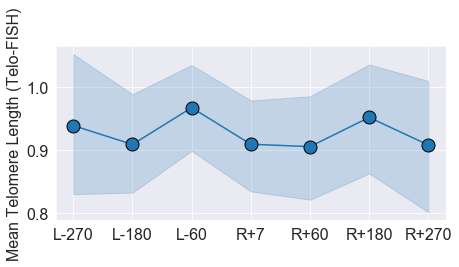

In [297]:
df = astro_telofish_grouped.copy()
df['style'] = 1
df = telo_ma.set_categories_sort(telomere_df=df)

x='timepoint'
y='telo means'
# x_label='Time point'
y_label='Mean Telomere Length (Telo-FISH)'


plt.figure(figsize=(7, 3.2))
fontsize=16
ax = sns.lineplot(x=x, y=y, data=df, style='style', markers=True, legend=False,
                  **{'markersize':13, 'mec':'black', 'mew':1}
#                   hue='astro id',
#                   palette=sns.color_palette("Set2", astro_telofish_grouped['astro id'].nunique())
                 )

plt.xlabel('', fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)
plt.tick_params(labelsize=fontsize)

plt.savefig(f'../MANUSCRIPT 11 ASTROS/figures/11 astros lineplot {y_label} all timepoints.png', dpi=600,
            bbox_inches='tight')

## Longitudinal clustering of Telo-FISH data

### Clustering 11 astros by Telo-FISH data (all timepoints or L-270/R+7/R+270)

In [77]:
astro_telos_per_cell_df = pd.read_csv('../data/compiled and processed data/exploded_cells_astros_df.csv')
astro_telofish_grouped = astro_telos_per_cell_df.groupby(by=['astro id', 
                                                             'timepoint', 
                                                             'flight status']).agg('mean').reset_index()
telofish_cluster_rdy_df = telo_ma.ext_telo_data_longitudinal_clustering(telomere_df=astro_telofish_grouped)

In [78]:
knn_telofish = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(telofish_cluster_rdy_df.copy()))
knn_telofish = telo_ma.rename_imputed_df(imputed_df=knn_telofish, original_df=telofish_cluster_rdy_df)
knn_telofish_3 = knn_telofish[['L-270', 'R+7', 'R+270']].copy()

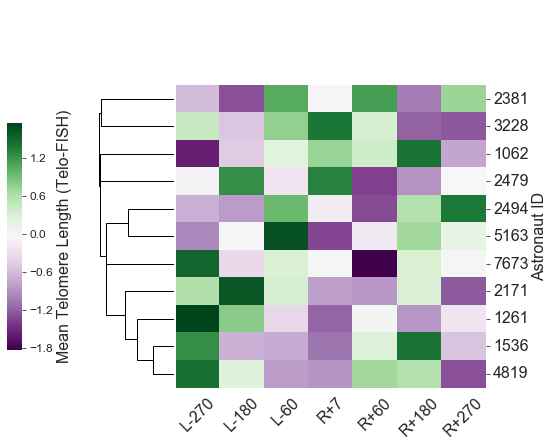

In [96]:
telo_ma.clustermap_plot(knn_telofish, z_score=0, save=True, fontsize=16,
                        path_labels='all timepoints')

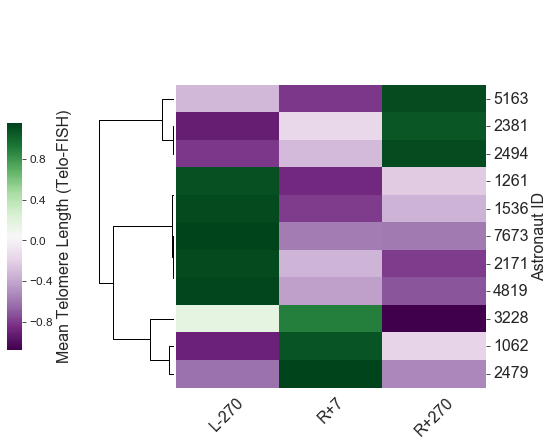

In [97]:
telo_ma.clustermap_plot(knn_telofish_3, z_score=0, save=True, metric='correlation', fontsize=16,
                        path_labels='3 timepoints')

In [79]:
knn_telofish_3['astro id'] = knn_telofish_3.index
knn_melt_fish_3 = knn_telofish_3.melt(id_vars='astro id', 
                                  var_name='timepoint', 
                                  value_name='telo means')
knn_melt_fish_3.rename({'telo means':'Mean Telomere Length (Telo-FISH)'}, axis=1, inplace=True)

In [80]:
knn_melt_fish_3['astro id'] = knn_melt_fish_3['astro id'].astype('str')
knn_melt_fish_3['Clustered groups'] = knn_melt_fish_3['astro id'].apply(lambda row: telo_ma.fish_assign_clustering(row))

In [280]:
import importlib
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


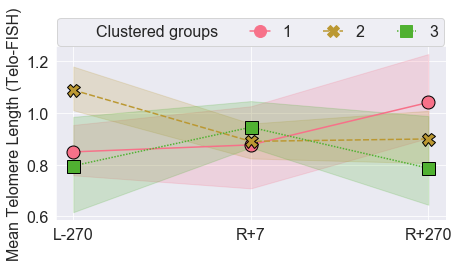

In [281]:
# clustered_graphing = clustered_telos.rename({'Mean Telomere Length (Telo-FISH) cluster groups': 'Clustered groups'}, 
#                                             axis=1).copy()

clustered_graphing = telo_ma.set_categories_sort(telomere_df=knn_melt_fish_3, 
                                                 sort_list=['L-270', 'R+7', 'R+270'])
telo_ma.graph_cluster_groups(clustered_graphing, 
                             target='Mean Telomere Length (Telo-FISH)',
                             y_label_name='Mean Telomere Length (Telo-FISH)',
                             time='timepoint',
                             hue='Clustered groups',
                             colors='husl',
                             n_cols=4,
                             figsize=(7, 3.2),
                             fontsize=16,
                             bbox_to_anchor=(.5, 1.21),
                             markersize=13,
                             save=True,
                            )

### Clustering 3 astros by Telo-FISH data (flight status)

In [298]:
knn_telofish = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(telofish_cluster_rdy_df.copy()))
knn_telofish = telo_ma.rename_imputed_df(imputed_df=knn_telofish, original_df=telofish_cluster_rdy_df)
knn_telofish['astro id'] = knn_telofish.index
knn_telofish_3_astros = knn_telofish[knn_telofish['astro id'].isin([2171, 5163, 1536])].copy()

In [299]:
grouped_3 = astro_telofish_grouped[astro_telofish_grouped['astro id'].isin([2171, 5163, 1536])].copy()

pivot_3 = grouped_3.pivot_table(index='astro id', columns='flight status', values='telo means')
pivot_3 = pivot_3[['Pre-Flight', 'Mid-Flight', 'Post-Flight']]

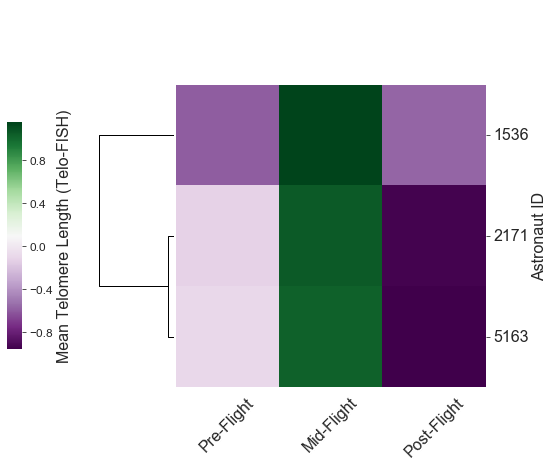

In [300]:
telo_ma.clustermap_plot(pivot_3, z_score=0, save=True, fontsize=16, metric='euclidean',
                        path_labels='3 astros pre mid post')

In [301]:
pivot_3['astro id'] = pivot_3.index
melt_3 = pivot_3.melt(id_vars='astro id', 
                      var_name='flight status', 
                      value_name='telo means')

melt_3.rename({'telo means':'Mean Telomere Length (Telo-FISH)'}, axis=1, inplace=True)
melt_3['astro id'] = melt_3['astro id'].astype('str')
melt_3['Clustered groups'] = melt_3['astro id'].apply(lambda row: 1 if row == '1536' else 2)

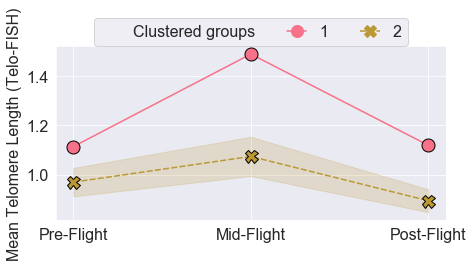

In [302]:
clustered_graphing = telo_ma.set_categories_sort(telomere_df=melt_3,
                                                 time='flight status',
                                                 sort_list=['Pre-Flight', 'Mid-Flight', 'Post-Flight'])
telo_ma.graph_cluster_groups(clustered_graphing, 
                             target='Mean Telomere Length (Telo-FISH)',
                             y_label_name='Mean Telomere Length (Telo-FISH)',
                             time='flight status',
                             hue='Clustered groups',
                             colors='husl',
                             n_cols=4,
                             figsize=(7, 3.2),
                             fontsize=16,
                             bbox_to_anchor=(.5, 1.21),
                             path_labels='3 astros 3 flight status',
                            )

# Analyzing Mean Telomere Lengths (qPCR))
---

## Reading in telomere length (qPCR) data

In [7]:
# astronauts telomere qpcr df
astro_telos_qpcr_df = pd.read_excel('../data/raw data/qpcr_telomere_astros.xlsx', usecols=[0, 1, 2])
astro_telos_qpcr_df.dropna(axis=0, inplace=True)
astro_telos_qpcr_df['astro id'] = astro_telos_qpcr_df['astro id'].astype('int64')    
astro_telos_qpcr_df['flight status'] = astro_telos_qpcr_df['timepoint'].apply(lambda row: telo_ma.flight_status(row))

In [8]:
astro_telos_qpcr_grouped = (astro_telos_qpcr_df.groupby(by=['astro id', 'timepoint', 'flight status'])
                                               .agg('mean').reset_index())

astro_telos_qpcr_grouped['timepoint'] = astro_telos_qpcr_grouped['timepoint'].apply(lambda row: telo_ma.convert_mid_timepoint(row))

In [10]:
# controls telomere qpcr df
controls_telos_qpcr_df = pd.read_excel('../data/raw data/qpcr_telomere_astros.xlsx', usecols=[5, 6, 7])
controls_telos_qpcr_df.dropna(axis=0, inplace=True)
controls_telos_qpcr_df['control id'] = controls_telos_qpcr_df['control id'].astype('int64')
controls_telos_qpcr_df.rename({'timepoint.1': 'timepoint', 'Mean Telomere Length (qPCR).1': 'Mean Telomere Length (qPCR)'},
                              axis=1, inplace=True)

controls_telos_qpcr_df['flight status'] = 'Controls'

In [11]:
print(controls_telos_qpcr_df.shape)

for status in ['Pre-Flight', 'Mid-Flight', 'Post-Flight']:
    print(astro_telos_qpcr_df[astro_telos_qpcr_df['flight status'] == status].shape)

(233, 4)
(95, 4)
(18, 4)
(127, 4)


## Mean Telomere Lengths for 11 Astros: Visualizations, Stats (qPCR)

First.. let's see how mean telomere length changes w/ respect to spaceflight when all 11 astronauts are averaged together for pre-, mid-, & post-flight timepoints

In [12]:
concat_astros_ctrl = pd.concat([astro_telos_qpcr_df.assign(dataset='set1'),
                                controls_telos_qpcr_df.assign(dataset='set2')], sort=False)

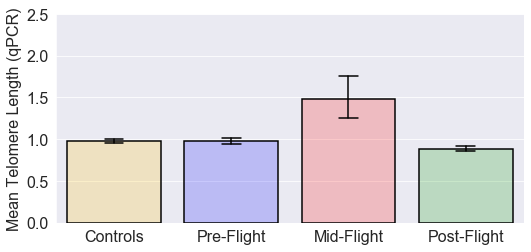

In [13]:
plt.figure(figsize=(8.4, 3.84))
fontsize=16

ax = sns.barplot(x='flight status', y='Mean Telomere Length (qPCR)', data=concat_astros_ctrl, 
                 order=['Controls', 'Pre-Flight', 'Mid-Flight', 'Post-Flight'],
                 alpha=None, capsize=0.16, linewidth=1.5, errwidth=1, **{'edgecolor':'black'},
                 ci=95, )

# set alpha to None, enabling assignment of preferred colors to each bar while
# retaining alpha=1 on bar edges
for i, value in enumerate(['#FFC000', '#0000FF', '#FF0000', '#009900']):
    colors = mc.to_rgba(value)
    empty = (colors[0], colors[1], colors[2], 0.2)
    ax.patches[i].set_facecolor(empty)

plt.setp(ax.lines, color='black', linewidth=1.5)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Mean Telomere Length (qPCR)', fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylim(0, 2.5)

plt.savefig('../MANUSCRIPT 11 ASTROS/figures/mean telomere length (qPCR) 11 unrelated astronuats pre mid post.png', dpi=600)

In [754]:
telo_ma.telos_scipy_anova_post_hoc_tests(df0=concat_astros_ctrl, time_col='flight status', 
                                         target='Mean Telomere Length (qPCR)',
                                         sig_test=stats.f_oneway, post_hoc=None, repeated_measures=False)

ONE WAY ANOVA for telomere length: 1.0874380074447757e-19
   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower   upper  reject
-------------------------------------------------------
  Controls   Mid-Flight   0.5     0.3618  0.6382  True 
  Controls  Post-Flight  -0.09   -0.1523 -0.0277  True 
  Controls   Pre-Flight -0.0024  -0.0711  0.0664 False 
 Mid-Flight Post-Flight -0.5899  -0.7322 -0.4476  True 
 Mid-Flight  Pre-Flight -0.5023  -0.6476 -0.3571  True 
Post-Flight  Pre-Flight  0.0876   0.011   0.1642  True 
-------------------------------------------------------
TukeyHSD pvalues: [0.001, 0.0012629068841544244, 0.9, 0.001, 0.001, 0.017656696315270115]


### Lineplot

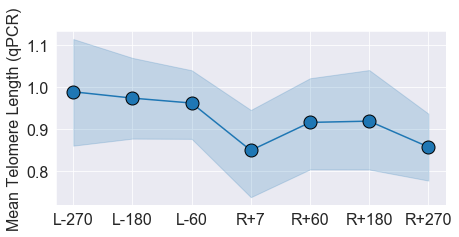

In [282]:
df = astro_telos_qpcr_grouped.copy()
df['style'] = 1
df = telo_ma.set_categories_sort(telomere_df=df)

x='timepoint'
y='Mean Telomere Length (qPCR)'
x_label='Time point'
y_label='Mean Telomere Length (qPCR)'


plt.figure(figsize=(7, 3.2))
fontsize=16
ax = sns.lineplot(x=x, y=y, data=df, style='style', markers=True, legend=False,
                  **{'markersize':13, 'mec':'black', 'mew':1}
#                   hue='astro id',
#                   palette=sns.color_palette("Set2", astro_telofish_grouped['astro id'].nunique())
                 )

plt.xlabel('', fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)
plt.tick_params(labelsize=fontsize)

plt.savefig(f'../MANUSCRIPT 11 ASTROS/figures/11 astros lineplot {y} all timepoints.png', dpi=600,
           bbox_inches='tight')

## Longitudinal clustering of telomere (qPCR) data

### Clustering 11 astros by telomere qPCR data (all timepoints or L-270/R+7/R+270)

In [261]:
# astronauts telomere qpcr df
astro_telos_qpcr_df = pd.read_excel('../data/raw data/qpcr_telomere_astros.xlsx', usecols=[0, 1, 2])
astro_telos_qpcr_df.dropna(axis=0, inplace=True)
astro_telos_qpcr_df['astro id'] = astro_telos_qpcr_df['astro id'].astype('int64')    
astro_telos_qpcr_df['flight status'] = astro_telos_qpcr_df['timepoint'].apply(lambda row: telo_ma.flight_status(row))

astro_telos_qpcr_grouped = (astro_telos_qpcr_df.groupby(by=['astro id', 'timepoint', 'flight status']).agg('mean').reset_index())
astro_telos_qpcr_grouped['timepoint'] = astro_telos_qpcr_grouped['timepoint'].apply(lambda row: telo_ma.convert_mid_timepoint(row))

In [262]:
telo_qpcr_cluster_rdy_df = telo_ma.ext_telo_data_longitudinal_clustering(telomere_df=astro_telos_qpcr_grouped,
                                                                         telomere_col_name='Mean Telomere Length (qPCR)')

In [263]:
knn_telo_qpcr = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(telo_qpcr_cluster_rdy_df.copy()))
knn_telo_qpcr = telo_ma.rename_imputed_df(imputed_df=knn_telo_qpcr, original_df=telo_qpcr_cluster_rdy_df)

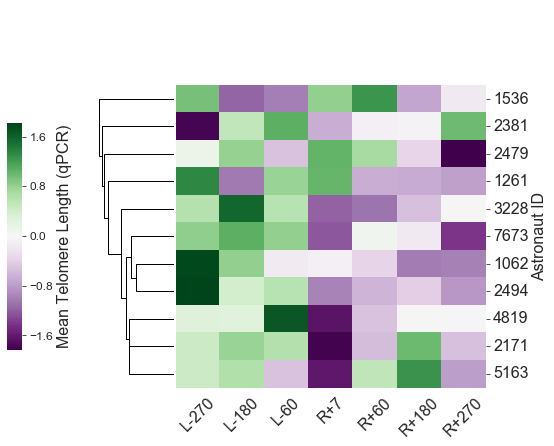

In [264]:
telo_ma.clustermap_plot(knn_telo_qpcr, y_label='Mean Telomere Length (qPCR)', 
                        metric='euclidean', save=True, z_score=0, fontsize=16,
                        path_labels='all timepoints')

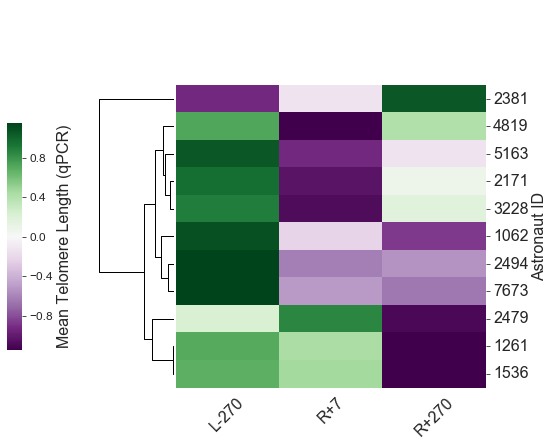

In [265]:
knn_telo_qpcr_3 = knn_telo_qpcr[['L-270', 'R+7', 'R+270']].copy()
telo_ma.clustermap_plot(knn_telo_qpcr_3, y_label='Mean Telomere Length (qPCR)', 
                        metric='euclidean', save=True, z_score=0, fontsize=16,
                        path_labels='3 timepoints')

In [268]:
knn_telo_qpcr_3['astro id'] = knn_telo_qpcr_3.index
knn_melt_3 = knn_telo_qpcr_3.melt(id_vars='astro id', 
                                  var_name='timepoint', 
                                  value_name='Mean Telomere Length (qPCR)')

In [269]:
knn_melt_3['Clustered groups'] = knn_melt_3['astro id'].astype('str').apply(lambda row: telo_ma.qpcr_assign_cluster(row))

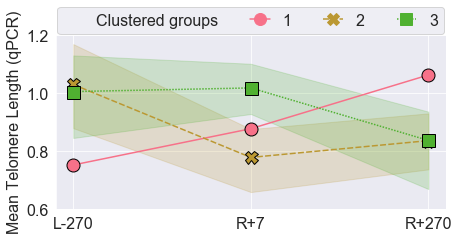

In [284]:
clustered_graphing = telo_ma.set_categories_sort(telomere_df=knn_melt_3, sort_list=['L-270', 'R+7', 'R+270'])
telo_ma.graph_cluster_groups(clustered_graphing, 
                             target='Mean Telomere Length (qPCR)',
                             y_label_name='Mean Telomere Length (qPCR)',
                             time='timepoint',
                             hue='Clustered groups',
                             colors='husl',
                             n_cols=4,
                             figsize=(7, 3.2),
                             fontsize=16,
                             bbox_to_anchor=(.5, 1.21),
                             y_lim=(0.6, 1.2),
                             save=True,
                            )

### Clustering 3 astros by telomere qPCR data (flight status)

In [ ]:
# knn_telofish = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(telofish_cluster_rdy_df.copy()))
# knn_telofish = telo_ma.rename_imputed_df(imputed_df=knn_telofish, original_df=telofish_cluster_rdy_df)
# knn_telofish['astro id'] = knn_telofish.index
# knn_telofish_3_astros = knn_telofish[knn_telofish['astro id'].isin([2171, 5163, 1536])].copy()

In [303]:
grouped_3 = astro_telos_qpcr_grouped[astro_telos_qpcr_grouped['astro id'].isin([2171, 5163, 1536])].copy()

pivot_3 = grouped_3.pivot_table(index='astro id', columns='flight status', values='Mean Telomere Length (qPCR)')
pivot_3 = pivot_3[['Pre-Flight', 'Mid-Flight', 'Post-Flight']]

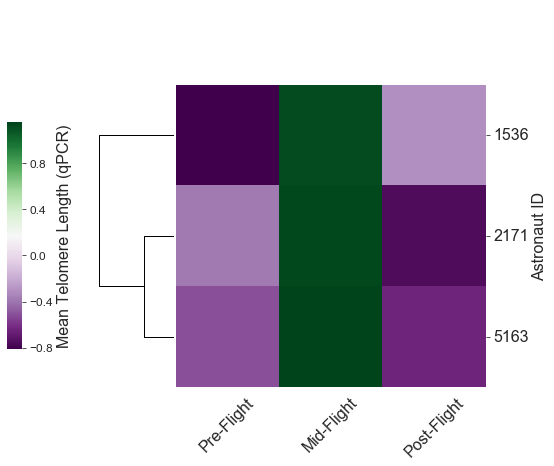

In [304]:
telo_ma.clustermap_plot(pivot_3, z_score=0, save=True, fontsize=16, metric='euclidean',
                        y_label='Mean Telomere Length (qPCR)',
                        path_labels='3 astros qPCR pre mid post')

In [305]:
pivot_3['astro id'] = pivot_3.index
melt_3 = pivot_3.melt(id_vars='astro id', 
                      var_name='flight status', 
                      value_name='Mean Telomere Length (qPCR)')

melt_3['astro id'] = melt_3['astro id'].astype('str')
melt_3['Clustered groups'] = melt_3['astro id'].apply(lambda row: 1 if row == '1536' else 2)

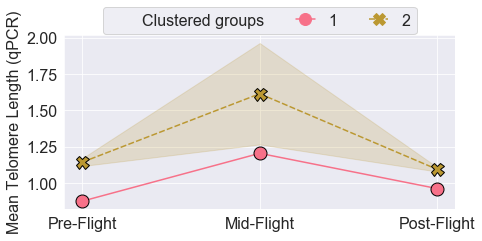

In [306]:
clustered_graphing = telo_ma.set_categories_sort(telomere_df=melt_3,
                                                 time='flight status',
                                                 sort_list=['Pre-Flight', 'Mid-Flight', 'Post-Flight'])
telo_ma.graph_cluster_groups(clustered_graphing, 
                             target='Mean Telomere Length (qPCR)',
                             y_label_name='Mean Telomere Length (qPCR)',
                             time='flight status',
                             hue='Clustered groups',
                             colors='husl',
                             n_cols=4,
                             figsize=(7, 3.2),
                             fontsize=16,
                             bbox_to_anchor=(.5, 1.21),
                             path_labels='3 astros 3 flight status',
                            )

## Mean Telomere Lengths for 3 Astros: Visualizations, Stats

In [ ]:
only_inflight_astros_df = (astro_telos_per_cell_df[astro_telos_per_cell_df
                                                   ['astro id'].isin(['2171', '1536', '5163'])].copy())

In [ ]:
only_inflight_concat_astros_ctrl_per_cell = pd.concat([only_inflight_astros_df.assign(dataset='set1'),
    ctrl_telos_per_cell_df.assign(dataset='set2')], sort=False)

In [ ]:
ax = sns.barplot(x='flight status', y='telo data per cell', data=only_inflight_concat_astros_ctrl_per_cell, 
            order=['Controls', 'Pre-Flight', 'Mid-Flight', 'Post-Flight'])

ax.set_title('Mean Telomere Lengths for 3 Unrelated Astronauts Pre-, Mid-, & Post-Space Flight', fontsize=16)
ax.set_xlabel('Flight Status', fontsize=16)
ax.set_ylabel('Mean Telomere Length (per cell)', fontsize=14)

In [ ]:
only_inflight_astros_df.rename(columns={'flight status':'flight_status',
                                        'telo data per cell':'telo_data_per_cell',
                                        'astro id':'astro_id'}, inplace=True)

In [ ]:
data_AnovaRM = AnovaRM(only_inflight_astros_df,
                       'telo_data_per_cell',
                       'astro_id',
                       within=['flight_status'],
                       aggregate_func=np.mean).fit()
print(data_AnovaRM)

In [ ]:
telo_ma.scipy_anova_post_hoc_tests(df=only_inflight_astros_df, flight_status_col='flight_status', 
                                   target='telo_data_per_cell')

In [ ]:
for astro in only_inflight_astros_df['astro_id'].unique():
    df = only_inflight_astros_df[only_inflight_astros_df['astro_id'] == astro]

    print(f'dso{astro}')
    telo_ma.scipy_anova_post_hoc_tests(df=df, flight_status_col='flight_status', target='telo_data_per_cell')
    print('\n')

In [ ]:
for astro in only_inflight_astros_df['astro_id'].unique():
    df = only_inflight_astros_df[only_inflight_astros_df['astro_id'] == astro]

    print(f'dso{astro}')
    telo_ma.scipy_anova_post_hoc_tests(df=df, flight_status_col='flight_status', target='telo_data_per_cell')
    print('\n')

These 3 astronauts are our only individuals w/ inflight data, so the mid-flight mean telomere length has remained the same. The pre-/post-flight data has the same relationship compared to the data for all 11 astronauts: post-flight mean telomere length is *slightly* shorter.

Now.. our inflight astronauts had blood samples collected at different flight days. Let's first parse out the mean telomere length data per astronaut.

## Examining Mean Telomere Length @ Mid-Flight 1 vs. 2

In [ ]:
fig = plt.figure(figsize=(11,6))
ax = sns.barplot(x='flight status', y='telo data per cell', order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], 
                   hue='astro id', data=only_inflight_astros_df, dodge=True)

ax.set_title('Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid-, Post-Flight', fontsize=14)

Even when considered separately, for each astronaut the average of mean telomere length for their samples taken midflight was always longer than the average of samples pre-flight. As well, the average of mean telomere length for samples post-flight were slightly shorter. Interestingly, dso2171 looks to have similar mean telomere length for both blood draws.

Now we must consider if mean telomere length increases as a function of *duration in spaceflight*. We can do so b.c astros 1536&5163 samples were collected at FD90 & 140, while astro 2171 samples were collected at FD45 & 260. Let's first parse out the two mid-flight timepoints, then examine mid 1 & mid 2 for each astronaut

In [ ]:
only_inflight_astros_df['flight status mid split'] = only_inflight_astros_df.loc[:, 'timepoint'].apply(lambda row: telo_ma.mid_split(row))
ctrl_telos_per_cell_df['flight status mid split'] = 'Controls'

In [ ]:
only_inflight_concat_df = pd.concat([only_inflight_astros_df.assign(dataset='set1'),
                                     ctrl_telos_per_cell_df.assign(dataset='set2')], sort=False)

In [ ]:
fig = plt.figure(figsize=(11,6))
ax = sns.barplot(x='flight status mid split', y='telo data per cell', 
                   order=['Controls', 'Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], 
                 data=only_inflight_concat_df)

ax.set_title('Mean Telomere Lengths for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight', fontsize=14)

The average of mean telomere lengths for mid-flight 2 is certainly higher than for mid-flight 1. There may be some relationship between telomere lengthening and spaceflight duration. However, telomere length may have a normal biological upper bound, though numerically undefined, thus it's unlikely that telomere length would increase indefinitely via spaceflight. Let's see how the data looks per astronaut.

In [ ]:
fig = plt.figure(figsize=(11,6))
ax = sns.barplot(x='flight status mid split', y='telo data per cell', order=['Pre-Flight', 'Mid-Flight 1', 'Mid-Flight 2', 'Post-Flight'], 
                   hue='astro id', data=only_inflight_astros_df, dodge=True)

ax.set_title('Mean Telomere Lengths per Astronaut for 3 Unrelated Astronauts: Pre-, Mid 1-, Mid 2-, Post-Flight')

Astros 1536 & 5163 blood draws occured at FD90 & FD140, and both experienced an increase in mean telomere length at mid-flight 1 relative to pre-flight, and experienced an additional increase over mid-flight 1 at mid-flight 2.

Astro 2171 had blood draws at FD45 & FD260, and while mid-flight 1 had increased mean telomere length relative to pre-flight, mid-flight 2 was not. Rather, mid-flight 2 was numerically close to mid-flight 1. Altogether, mean telomere length does not appear to increase indefinitely with spaceflight. Our limited # of datapoints suggest that while mean telomere length increases mid-flight, it does not increase indefinitely.

Let's look at individual telomere lengths.

# Analyzing Individual Telomere Length Distributions (FISH)

## Reading data

In [ ]:
exploded_telos_astro_df = pd.read_csv('../data/compiled and processed data/exploded_telos_astros_df.csv')
exploded_telos_astro_df['astro id'] = exploded_telos_astro_df['astro id'].astype('str')

## Graphing individual telos per cluster (identified w/ Telo-FISH data, above)

In [ ]:
# pulling out L-270 / R+270
parsed_L270_R270 = exploded_telos_astro_df[exploded_telos_astro_df['timepoint'].isin(['L-270', 'R+270'])].copy()

In [ ]:
# swapping 2171 L-180 & 5163 R+180 data w/ L-270 & R+270 to facilitate analysis of most distal pre/post timepoints
df = exploded_telos_astro_df.copy()

parsed_2171_L180_to_270 = df[(df['astro id'] == '2171') & (df['timepoint'] == 'L-180')].copy()
parsed_2171_L180_to_270['timepoint'] = 'L-270'

parsed_5163_R180_to_270 = df[(df['astro id'] == '2171') &  (df['timepoint'] == 'R+180')].copy()
parsed_5163_R180_to_270['timepoint'] = 'R+270'

parsed_df = pd.concat([parsed_L270_R270, 
                       parsed_2171_L180_to_270,
                       parsed_5163_R180_to_270], axis=0)

parsed_df['Clustered group'] = parsed_df['astro id'].apply(lambda row: telo_ma.fish_assign_clustering(row))

In [ ]:
for num in [1, 2, 3]:

    grp_df = parsed_df.groupby('Clustered group')
    get_group = grp_df.get_group(num)

    quartile_ref = get_group[get_group['timepoint'] == 'L-270']['telo data exploded']
    df1 = get_group[get_group['timepoint'] == 'L-270']['telo data exploded']
    df2 = get_group[get_group['timepoint'] == 'R+270']['telo data exploded']

    name1=f'Cluster group {num} Earliest Pre-Flight'
    name2=f'Cluster group {num} Latest Post-Flight'
    n_bins=40

    telo_ma.graph_two_histograms_grp(quartile_ref, n_bins, df1, df2, name1, name2, path_labels=f'{num} astros', save=True)

### Graphing midflight separately

In [ ]:
# taking only midflight astros
exploded_telos_only_mid_astros_df = exploded_telos_astro_df[exploded_telos_astro_df['astro id'].isin(['5163', 
                                                                                                      '1536', 
                                                                                                      '2171'])].copy()
exploded_telos_only_mid_astros_df.shape

In [ ]:
exploded_telos_only_mid_astros_df['flight status mid split'] = (exploded_telos_only_mid_astros_df['timepoint']
                                                                .apply(lambda row: telo_ma.mid_split(row)))

We've seen that mean telomere length increases during spaceflight. Now let us define short&long telomeres and visualize individual telomere length distributions per astronaut for timepoints most distal to spaceflight. 

To define short & long telomeres, we'll first find the earliest pre-flight samples for each astronaut. Then, in the individual telomere length distribution for that sample, we'll find the quartile boundary values for the bottom 25% of telos (short telos), middle 50%, and top 25% (long telos). The short, medium, and long telomeres will be colored yellow, blue, and pink respectively.

Once the quartile boundary values are established by the earliest pre-flight timepoint, the quartile boundary values will be used to color both midflight samples and the latest post-flight sample. In doing so, we can visualize and quantify the shifts of short/mid/long telomeres for each sample relative to the earliest timepoint. Now we have a means to discuss these classes of telomeres.

In [ ]:
exploded_telos_only_mid_astros_df['encoded astro id'] = (exploded_telos_only_mid_astros_df['astro id']
                                                         .apply(lambda row: telo_ma.id_encode_letters(row)))

## Telo Distributions: 3 Inflight Astros

In [ ]:
exploded_telos_only_mid_astros_df['encoded astro id'] = (exploded_telos_only_mid_astros_df['encoded astro id']
                                                         .astype('str'))
astro_ids = list(exploded_telos_only_mid_astros_df['encoded astro id'].unique())
telo_ma.make_histograms_colored_by_quartile_for_encoded_astronauts(exploded_telos_only_mid_astros_df, astro_ids,
                                                                   n_bins=45)

## Statistics

In [ ]:
df = exploded_telos_only_mid_astros_df.copy()
stats_df = pd.DataFrame()

astro_ids = ['2171', '1536', '5163']
timepoints = [['L-180', 'FD45', 'FD260', 'R+270'],
              ['L-270', 'FD90', 'FD140', 'R+270'],
              ['L-270', 'FD90', 'FD140', 'R+180']]

for astro_id, timepts in zip(astro_ids, timepoints):
    parse_df = df[(df['astro id'] == astro_id) & df['timepoint'].isin(timepts)].copy()
    print(astro_id)
    telo_ma.eval_make_test_comparisons(df=parse_df, timepoints=timepoints, target='telo data exploded',
                                       test=stats.mannwhitneyu, test_name='MannWhitney-U')
    print('\n')
#     stats_df = pd.concat([stats_df, parse_df], axis=0)

Intriguingly, we see a *decrease* in short telos and an *increase* in long telos inflight. Furthermore, 2/3 astronauts experienced a remarkable increase in short telomeres post-flight. Now, let us quantify and visualize the #s of short/medium/long telomeres for the complete timecourse for these 3 unrelated astronauts.

## Feature engineering short/long telos: 3 Inflight Astros

In [ ]:
melted_quartiles_astro_df = pd.read_csv('../data/compiled and processed data/melted_quartiles_astro_df.csv')
melted_quartiles_astro_df['astro id'] = melted_quartiles_astro_df['astro id'].astype('str')

In [ ]:
# inflight astros w/ timepoints graphed above
df_m = melted_quartiles_astro_df.copy()

dso2171_quartiles = df_m[(df_m['astro id'] == '2171') &
                         (df_m['timepoint'].isin(['L-180', 'FD45', 'FD260', 'R+270']))]

dso1536_quartiles = df_m[(df_m['astro id'] == '1536') &
                         (df_m['timepoint'].isin(['L-270', 'FD90', 'FD140', 'R+270']))]

dso5163_quartiles = df_m[(df_m['astro id'] == '5163') &
                         (df_m['timepoint'].isin(['L-270', 'FD90', 'FD140', 'R+180']))]

mid_only_quartiles_df = pd.concat([dso2171_quartiles, dso1536_quartiles, dso5163_quartiles])

In [ ]:
fig = plt.figure(figsize=(10,4))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status', y='Q freq counts', hue='relative Q', 
                   order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], 
                   data=mid_only_quartiles_df, palette=palette,
                   linewidth=2, saturation=5, color="black")

ax = sns.swarmplot(x='flight status', y='Q freq counts', hue='relative Q', 
                   order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], 
                   data=mid_only_quartiles_df, palette=palette,
                   linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_xlabel('timepoint', fontsize=14)
ax.set_ylabel('Counts of Individual Telomeres', fontsize=14)
ax.tick_params(labelsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='small')

In [ ]:
mid_only_quartiles_df['flight status mid split'] = (mid_only_quartiles_df['timepoint']
                                                        .apply(lambda row: telo_ma.mid_split(row)))

In [ ]:
fig = plt.figure(figsize=(18,8))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status mid split', y='Q freq counts', hue='relative Q', data=mid_only_quartiles_df, palette=palette,
             linewidth=2, saturation=5, color="black")
ax = sns.swarmplot(x='flight status mid split', y='Q freq counts', hue='relative Q', data=mid_only_quartiles_df, palette=palette,
             linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_title('3 Unrelated Astronauts Changes in Distribution of Individual Telomeres Relative to Quartiles of 1st Timepoint:\n Pre-. Mid-, Post-Flight', fontsize=14)
ax.set_xlabel('Flight Status', fontsize=14)
ax.set_ylabel('Individual Telos Freqs Within first time point Quartiles', fontsize=14)

In [ ]:
%reload_ext autoreload

##  Telo Distributions: ALL astros (less 3 inflight)

In [ ]:
# excluding midflight astros (analyzed above..); just pre/post data
exploded_telos_less_mid_astros_df = exploded_telos_astro_df[
                              (exploded_telos_astro_df['astro id'] != '5163') &
                              (exploded_telos_astro_df['astro id'] != '1536') &
                              (exploded_telos_astro_df['astro id'] != '2171')].copy()

astro_ids2 = list(exploded_telos_less_mid_astros_df['astro id'].unique())

In [ ]:
telo_ma.make_histograms_colored_by_quartile_for_astronauts(exploded_telos_less_mid_astros_df, astro_ids2)

## Statistics

In [ ]:
grouped_by_astro_id = exploded_telos_less_mid_astros_df.groupby('astro id')

for astro_id in list(exploded_telos_less_mid_astros_df['astro id'].unique()):
    grouped_by_one_astro_id = grouped_by_astro_id.get_group(astro_id)
    
    astro_pre = grouped_by_one_astro_id[grouped_by_one_astro_id['timepoint'] == 'L-270']['telo data exploded']
    astro_post = grouped_by_one_astro_id[grouped_by_one_astro_id['timepoint'] == 'R+270']['telo data exploded']
    
    telo_ma.statistics_between_timepoints_prepost_only(astro_pre, astro_post, f'astro ID {astro_id}: L-270', f'R+270')
    

## Feature engineering short/long telos: ALL astros (less 3 inflight)

In [ ]:
melted_quartiles_astro_df = pd.read_csv('../data/compiled and processed data/melted_quartiles_astro_df.csv')
melted_quartiles_astro_df['astro id'] = melted_quartiles_astro_df['astro id'].astype('str')

In [ ]:
d_m = melted_quartiles_astro_df[~melted_quartiles_astro_df['astro id'].isin(['2171', '5163', '1536'])]
# d_m = d_m[d_m['timepoint'].isin(['L-270', 'R+270'])].copy()
# test = pd.concat([d_m, mid_only_quartiles_df], axis=0)

In [ ]:
data = d_m

fig = plt.figure(figsize=(10,4))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='flight status', y='Q freq counts', hue='relative Q', 
#                    order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'], 
                   data=data, palette=palette,
                   linewidth=2, saturation=5, color="black")
ax = sns.swarmplot(x='flight status', y='Q freq counts', hue='relative Q', 
#                    order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'],
                   data=data, palette=palette,
                   linewidth=1, color="black", dodge=True)

ax=fig.gca()
ax.set_xlabel('timepoint', fontsize=14)
ax.set_ylabel('Counts of Individual Telomeres', fontsize=14)
ax.tick_params(labelsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='small')

## Making all controls individual telomere length histogram

In [ ]:
all_controls_df = pd.read_csv('../data/compiled data/All_astro_controls_telomere_length_dataframe.csv')
all_controls_df['telo data'] = all_controls_df['telo data'].apply(lambda row: np.array(literal_eval(row)))

all_controls_df.drop('flight status', axis=1, inplace=True)
print(all_controls_df.shape)

In [ ]:
explode_ctrl_telos_raw = all_controls_df['telo data'].apply(pd.Series)
exploded_telos_control_df = (explode_ctrl_telos_raw

    .merge(all_controls_df, right_index = True, left_index = True)                  
    .drop('telo data', axis=1)
    .melt(id_vars = ['control id', 'timepoint', 'flight status controls', 'telo means'], value_name = "telo data exploded") 
    .drop("variable", axis = 1)
    .dropna())

exploded_telos_control_df.shape

In [ ]:
exploded_telos_control_df = exploded_telos_control_df[(exploded_telos_control_df['timepoint'] != 'R+7') &
                          (exploded_telos_control_df['timepoint'] != 'R+5')]

exploded_telos_control_df['flight status controls'].value_counts()

In [ ]:
quartile_reference = exploded_telos_control_df[exploded_telos_control_df['flight status controls'] == 'Pre-Flight']['telo data exploded']
pre_f = exploded_telos_control_df[exploded_telos_control_df['flight status controls'] == 'Pre-Flight']['telo data exploded']
post_f = exploded_telos_control_df[exploded_telos_control_df['flight status controls'] == 'Post-Flight']['telo data exploded']

In [ ]:
n_bins = 45

telo_ma.graph_two_histograms(quartile_reference, n_bins, pre_f, post_f,
                             'Controls Pre-Flight', 'Controls Post-Flight', controls=True)

plt.savefig(f'../individual telomere length histogram distributions/png/ALL CONTROLS histogram of individual telomere length distributions.png', dpi=600)
plt.savefig(f'../individual telomere length histogram distributions/svg/ALL CONTROLS histogram of individual telomere length distributions.svg', format='svg', dpi=1500)

# Analyzing Telomerase Activity (qPCR)
---

## Reading in telomerase activity (qPCR, TRAP) data

In [790]:
# astronauts telomerase activity
astros_telomerase = pd.read_excel('../data/raw data/telomerase_telomere_astros.xlsx', usecols=[0, 1, 2])
astros_telomerase.dropna(axis=0, inplace=True)
astros_telomerase['astro id'] = astros_telomerase['astro id'].astype('int64')    
astros_telomerase['flight status'] = astros_telomerase['timepoint'].apply(lambda row: telo_ma.flight_status(row))

In [791]:
astros_telomerase_grouped = (astros_telomerase.groupby(by=['astro id', 'timepoint', 'flight status'])
                                               .agg('mean').reset_index())

astros_telomerase_grouped['timepoint'] = astros_telomerase_grouped['timepoint'].apply(lambda row: telo_ma.convert_mid_timepoint(row))

In [792]:
# controls telomerase activity
controls_telomerase = pd.read_excel('../data/raw data/qpcr_telomere_astros.xlsx', usecols=[5, 6, 7])
controls_telomerase.dropna(axis=0, inplace=True)
controls_telomerase['control id'] = controls_telomerase['control id'].astype('int64')
controls_telomerase.rename({'timepoint.1': 'timepoint', 'Mean Telomere Length (qPCR).1': 'Telomerase Activity (qPCR)'},
                              axis=1, inplace=True)

controls_telomerase['flight status'] = 'Controls'

In [793]:
print(controls_telomerase.shape)

for status in ['Pre-Flight', 'Mid-Flight', 'Post-Flight']:
    print(astros_telomerase[astros_telomerase['flight status'] == status].shape)

(233, 4)
(96, 4)
(18, 4)
(129, 4)


## Telomerase Activity for 11 Astros: Visualizations, Stats (qPCR)

First.. let's see how mean telomere length changes w/ respect to spaceflight when all 11 astronauts are averaged together for pre-, mid-, & post-flight timepoints

In [794]:
concat_astros_ctrl = pd.concat([astros_telomerase.assign(dataset='set1'),
                                controls_telomerase.assign(dataset='set2')], sort=False)

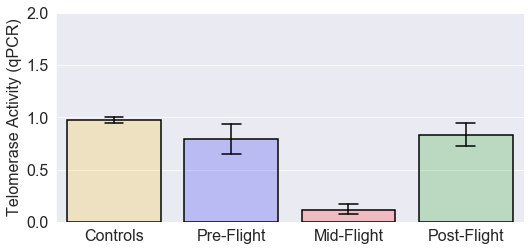

In [820]:
plt.figure(figsize=(8.4, 3.84))
fontsize=16

ax = sns.barplot(x='flight status', y='Telomerase Activity (qPCR)', data=concat_astros_ctrl, 
                 order=['Controls', 'Pre-Flight', 'Mid-Flight', 'Post-Flight'],
                 alpha=None, capsize=0.16, linewidth=1.5, errwidth=1, **{'edgecolor':'black'},
                 ci=95, )

# set alpha to None, enabling assignment of preferred colors to each bar while
# retaining alpha=1 on bar edges
for i, value in enumerate(['#FFC000', '#0000FF', '#FF0000', '#009900']):
    colors = mc.to_rgba(value)
    empty = (colors[0], colors[1], colors[2], 0.2)
    ax.patches[i].set_facecolor(empty)

plt.setp(ax.lines, color='black', linewidth=1.5)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Telomerase Activity (qPCR)', fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylim(0, 2)

plt.savefig('../MANUSCRIPT 11 ASTROS/figures/telomerase activitiy (qPCR) 11 unrelated astronuats pre mid post.png', 
            dpi=600, bbox_inches='tight')

In [771]:
concat_astros_ctrl.rename({'Telomerase Activity (qPCR)':'Telomerase_Activity_(qPCR)'}, axis=1, inplace=True)

In [772]:
telo_ma.telos_scipy_anova_post_hoc_tests(df0=concat_astros_ctrl, time_col='flight status', 
                                         target='Telomerase_Activity_(qPCR)',
                                         sig_test=stats.f_oneway, post_hoc=None, repeated_measures=False)

ONE WAY ANOVA for telomere length: 3.326470657864787e-05
   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower   upper  reject
-------------------------------------------------------
  Controls   Mid-Flight  -0.862   -1.154 -0.5699  True 
  Controls  Post-Flight -0.1484  -0.2794 -0.0174  True 
  Controls   Pre-Flight -0.1897  -0.3345 -0.0449  True 
 Mid-Flight Post-Flight  0.7136   0.4132  1.014   True 
 Mid-Flight  Pre-Flight  0.6723   0.3656  0.9789  True 
Post-Flight  Pre-Flight -0.0413  -0.2022  0.1196 False 
-------------------------------------------------------
TukeyHSD pvalues: [0.001, 0.01916394765649676, 0.004386238355270633, 0.001, 0.001, 0.9]


### Lineplot

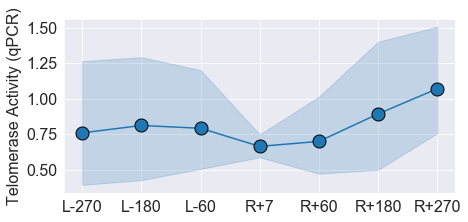

In [804]:
df = astros_telomerase_grouped.copy()
df['style'] = 1
df = telo_ma.set_categories_sort(telomere_df=df)

x='timepoint'
y='Telomerase Activity (qPCR)'
x_label='Time point'
y_label='Telomerase Activity (qPCR)'


plt.figure(figsize=(7, 3.2))
fontsize=16
ax = sns.lineplot(x=x, y=y, data=df, style='style', markers=True, legend=False,
                  **{'markersize':13, 'mec':'black', 'mew':1}
#                   hue='astro id',
#                   palette=sns.color_palette("Set2", astro_telofish_grouped['astro id'].nunique())
                 )

plt.xlabel('', fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)
plt.tick_params(labelsize=fontsize)

plt.savefig(f'../MANUSCRIPT 11 ASTROS/figures/11 astros lineplot {y} all timepoints.png', 
            dpi=600, bbox_inches='tight')

## Longitudinal clustering of telomere (qPCR) data

### Clustering 11 astros by telomere qPCR data (all timepoints or L-270/R+7/R+270)

In [797]:
# astronauts telomere qpcr df
astros_telomerase = pd.read_excel('../data/raw data/telomerase_telomere_astros.xlsx', usecols=[0, 1, 2])
astros_telomerase.dropna(axis=0, inplace=True)
astros_telomerase['astro id'] = astros_telomerase['astro id'].astype('int64')    
astros_telomerase['flight status'] = astros_telomerase['timepoint'].apply(lambda row: telo_ma.flight_status(row))

astros_telomerase_grouped = (astros_telomerase.groupby(by=['astro id', 'timepoint', 'flight status']).agg('mean').reset_index())
astros_telomerase_grouped['timepoint'] = astros_telomerase_grouped['timepoint'].apply(lambda row: telo_ma.convert_mid_timepoint(row))

In [798]:
telomerase_cluster_rdy_df = telo_ma.ext_telo_data_longitudinal_clustering(telomere_df=astros_telomerase_grouped,
                                                                         telomere_col_name='Telomerase Activity (qPCR)')

In [799]:
telomerase_cluster_rdy_df

timepoint     L-270     L-180      L-60       R+7      R+60     R+180  \
astro id                                                                
1062       0.674509  0.271202  0.667400  0.649613  0.874045  0.863536   
1261       1.033738  0.894380  0.701383  0.721196  0.358075  0.704535   
1536       0.104000  0.457354  0.720269  0.602822  0.801019  0.598778   
2171            NaN  0.220777  0.423708       NaN       NaN  0.267573   
2381       2.547032  0.831405  0.454232  0.646622  1.875382  0.688335   
2479       1.194454  2.910026  2.363233  0.957561  0.487935  1.112682   
2494       0.531910  0.464599  0.582253  0.599873  0.602063  1.567247   
3228       0.727024  0.366969  0.449289  0.418447  0.358181  0.410520   
4819       0.343638  0.330613  0.218980  0.598070  0.386014  0.470909   
5163       0.228144  0.471672  0.679855  0.657313  0.857604  0.149910   
7673       0.208350  1.706626  1.448717  0.792361  0.394007  2.986293   

timepoint     R+270  
astro id             
1062       0.776609  
1261       0.785062  
1536       0.574310  
2171       2.984439  
2381       1.004030  
2479       1.265791  
2494       0.756181  
3228       0.666213  
4819       0.458423  
5163       1.096603  
7673       1.398475

In [813]:
knn_telomerase = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(telomerase_cluster_rdy_df.copy()))
knn_telomerase = telo_ma.rename_imputed_df(imputed_df=knn_telomerase, original_df=telomerase_cluster_rdy_df)

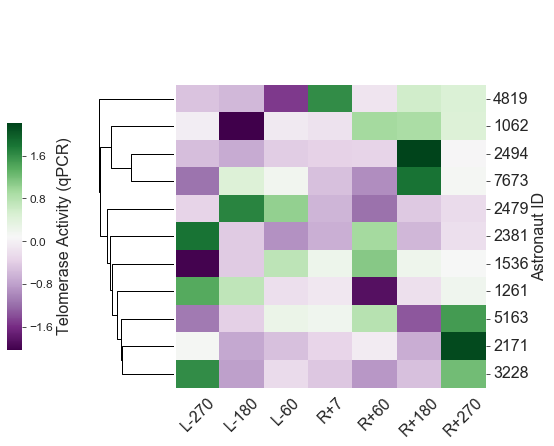

In [817]:
telo_ma.clustermap_plot(knn_telomerase, y_label='Telomerase Activity (qPCR)', 
                        metric='euclidean', save=True, z_score=0, fontsize=16,
                        path_labels='all timepoints')

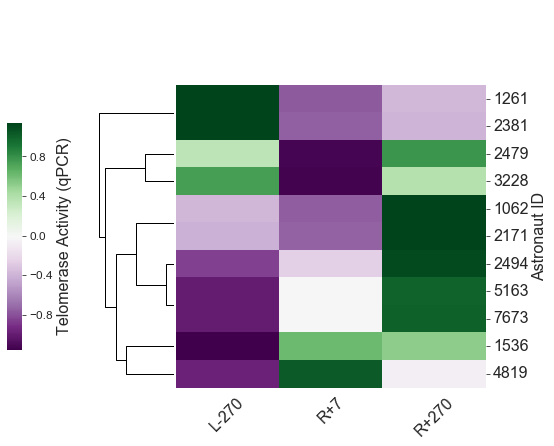

In [819]:
knn_telomerase3 = knn_telomerase[['L-270', 'R+7', 'R+270']].copy()
telo_ma.clustermap_plot(knn_telomerase3, y_label='Telomerase Activity (qPCR)', 
                        metric='euclidean', save=True, z_score=0, fontsize=16,
                        path_labels='3 timepoints')

# Correlating Urine/Blood Biochemistry Data (n=11) with telomere data
___

## Reading in telomere (qPCR / Telo-FISH) data for merge w/ biochem analytes

In [683]:
# 11 astronauts telo-fish df
astro_telos_per_cell_df = pd.read_csv('../data/compiled and processed data/exploded_cells_astros_df.csv')
astro_telofish_grouped = astro_telos_per_cell_df.groupby(by=['astro id', 'timepoint', 'flight status']).agg('mean').reset_index()
astro_telofish_grouped.rename({'telo means':'Mean Telomere Length (Telo-FISH)'}, axis=1, inplace=True)

In [382]:
# astronauts telomere qpcr df
astro_telos_qpcr_df = pd.read_excel('../data/raw data/qpcr_telomere_astros.xlsx', usecols=[0, 1, 2])
astro_telos_qpcr_df.dropna(axis=0, inplace=True)
astro_telos_qpcr_df['astro id'] = astro_telos_qpcr_df['astro id'].astype('int64')    
astro_telos_qpcr_df['flight status'] = astro_telos_qpcr_df['timepoint'].apply(lambda row: telo_ma.flight_status(row))

astro_telos_qpcr_grouped = (astro_telos_qpcr_df.groupby(by=['astro id', 'timepoint', 'flight status']).agg('mean').reset_index())
astro_telos_qpcr_grouped['timepoint'] = astro_telos_qpcr_grouped['timepoint'].apply(lambda row: telo_ma.convert_mid_timepoint(row))
astro_telos_qpcr_grouped = astro_telos_qpcr_grouped.merge(astro_telofish_grouped[['astro id', 'astro number']], on=['astro id']).copy()

## Blood analyte and mean telomere length (qPCR/Telo-FISH) correlations 

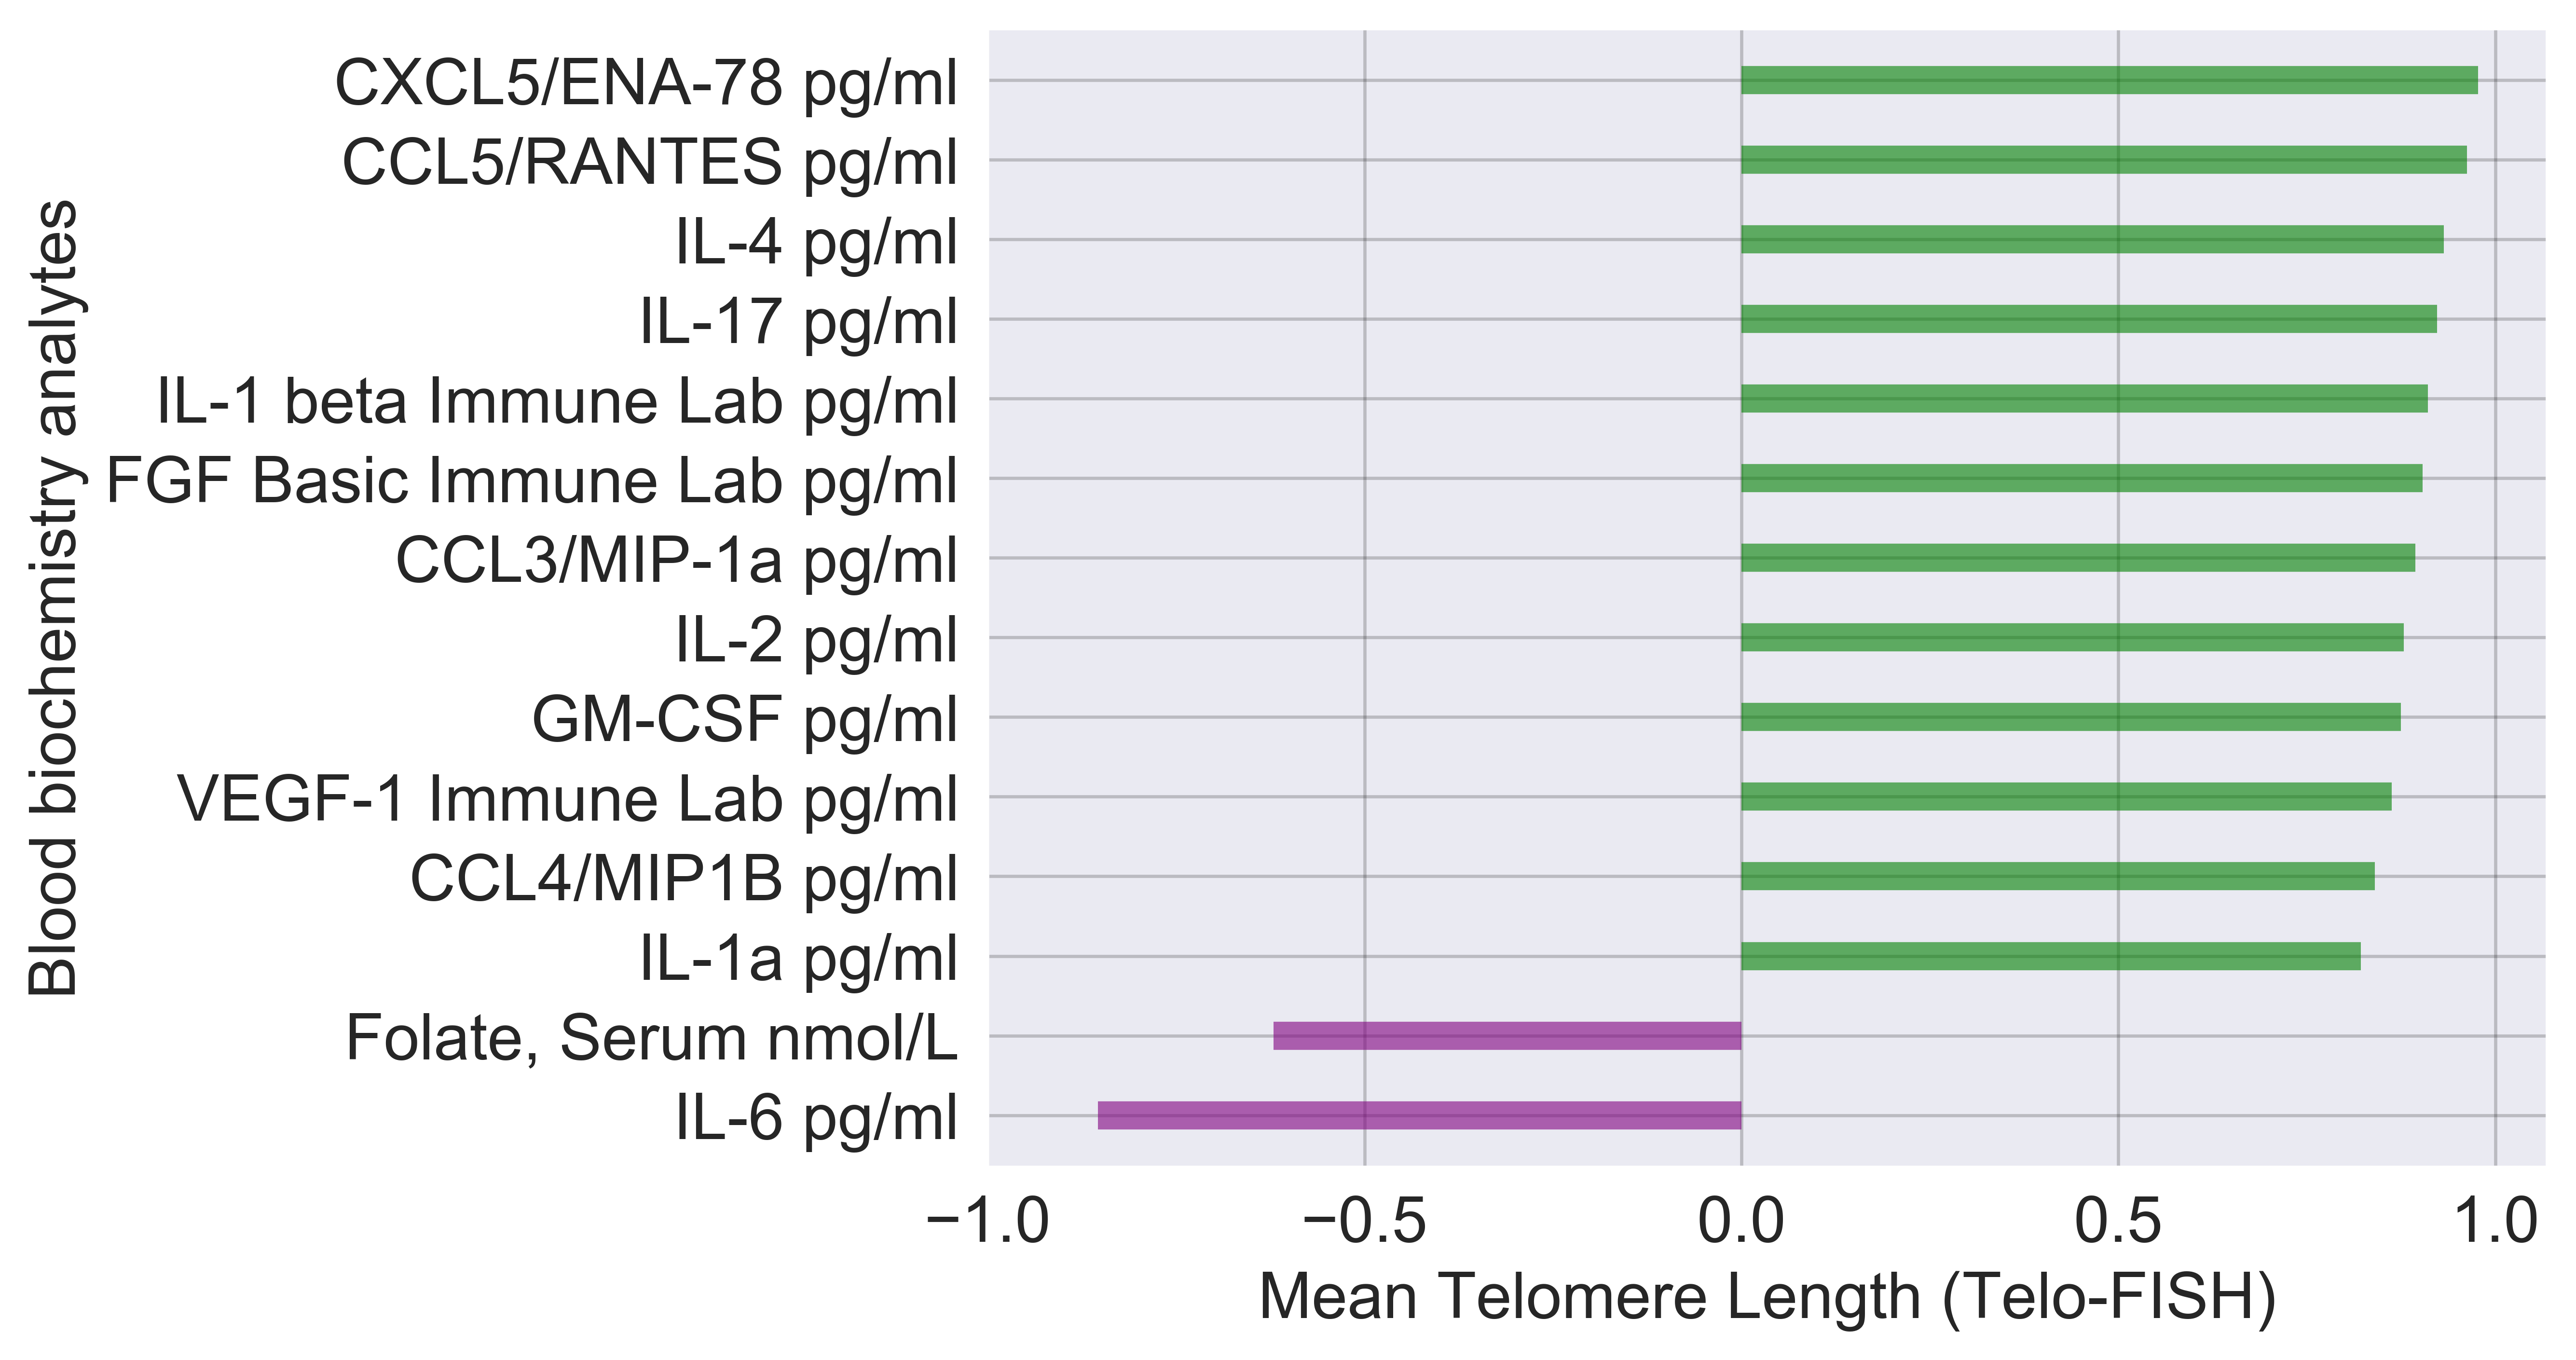

In [848]:
# mean telomere length (qPCR) parsed HIGH CORR blood analytes
melt_blood_biochem_data = pd.read_csv('../data/compiled and processed data/melt_blood_biochem_data.csv')

telo_ma.analyze_biochem_analytes_target(target='Mean Telomere Length (Telo-FISH)',
                                        df=astro_telofish_grouped,
                                        melt_biochem_df=melt_blood_biochem_data,
                                        color1='green',
                                        color2='purple',
                                        abs_value_corr=0.6,
                                        merge_telomere_biochem_data=True,
                                        parse_correlation_values=True,
                                        parse_corr_min=0,
                                        parse_corr_max=0.8,
                                        figsize=(9,4.8),
                                        save=False)

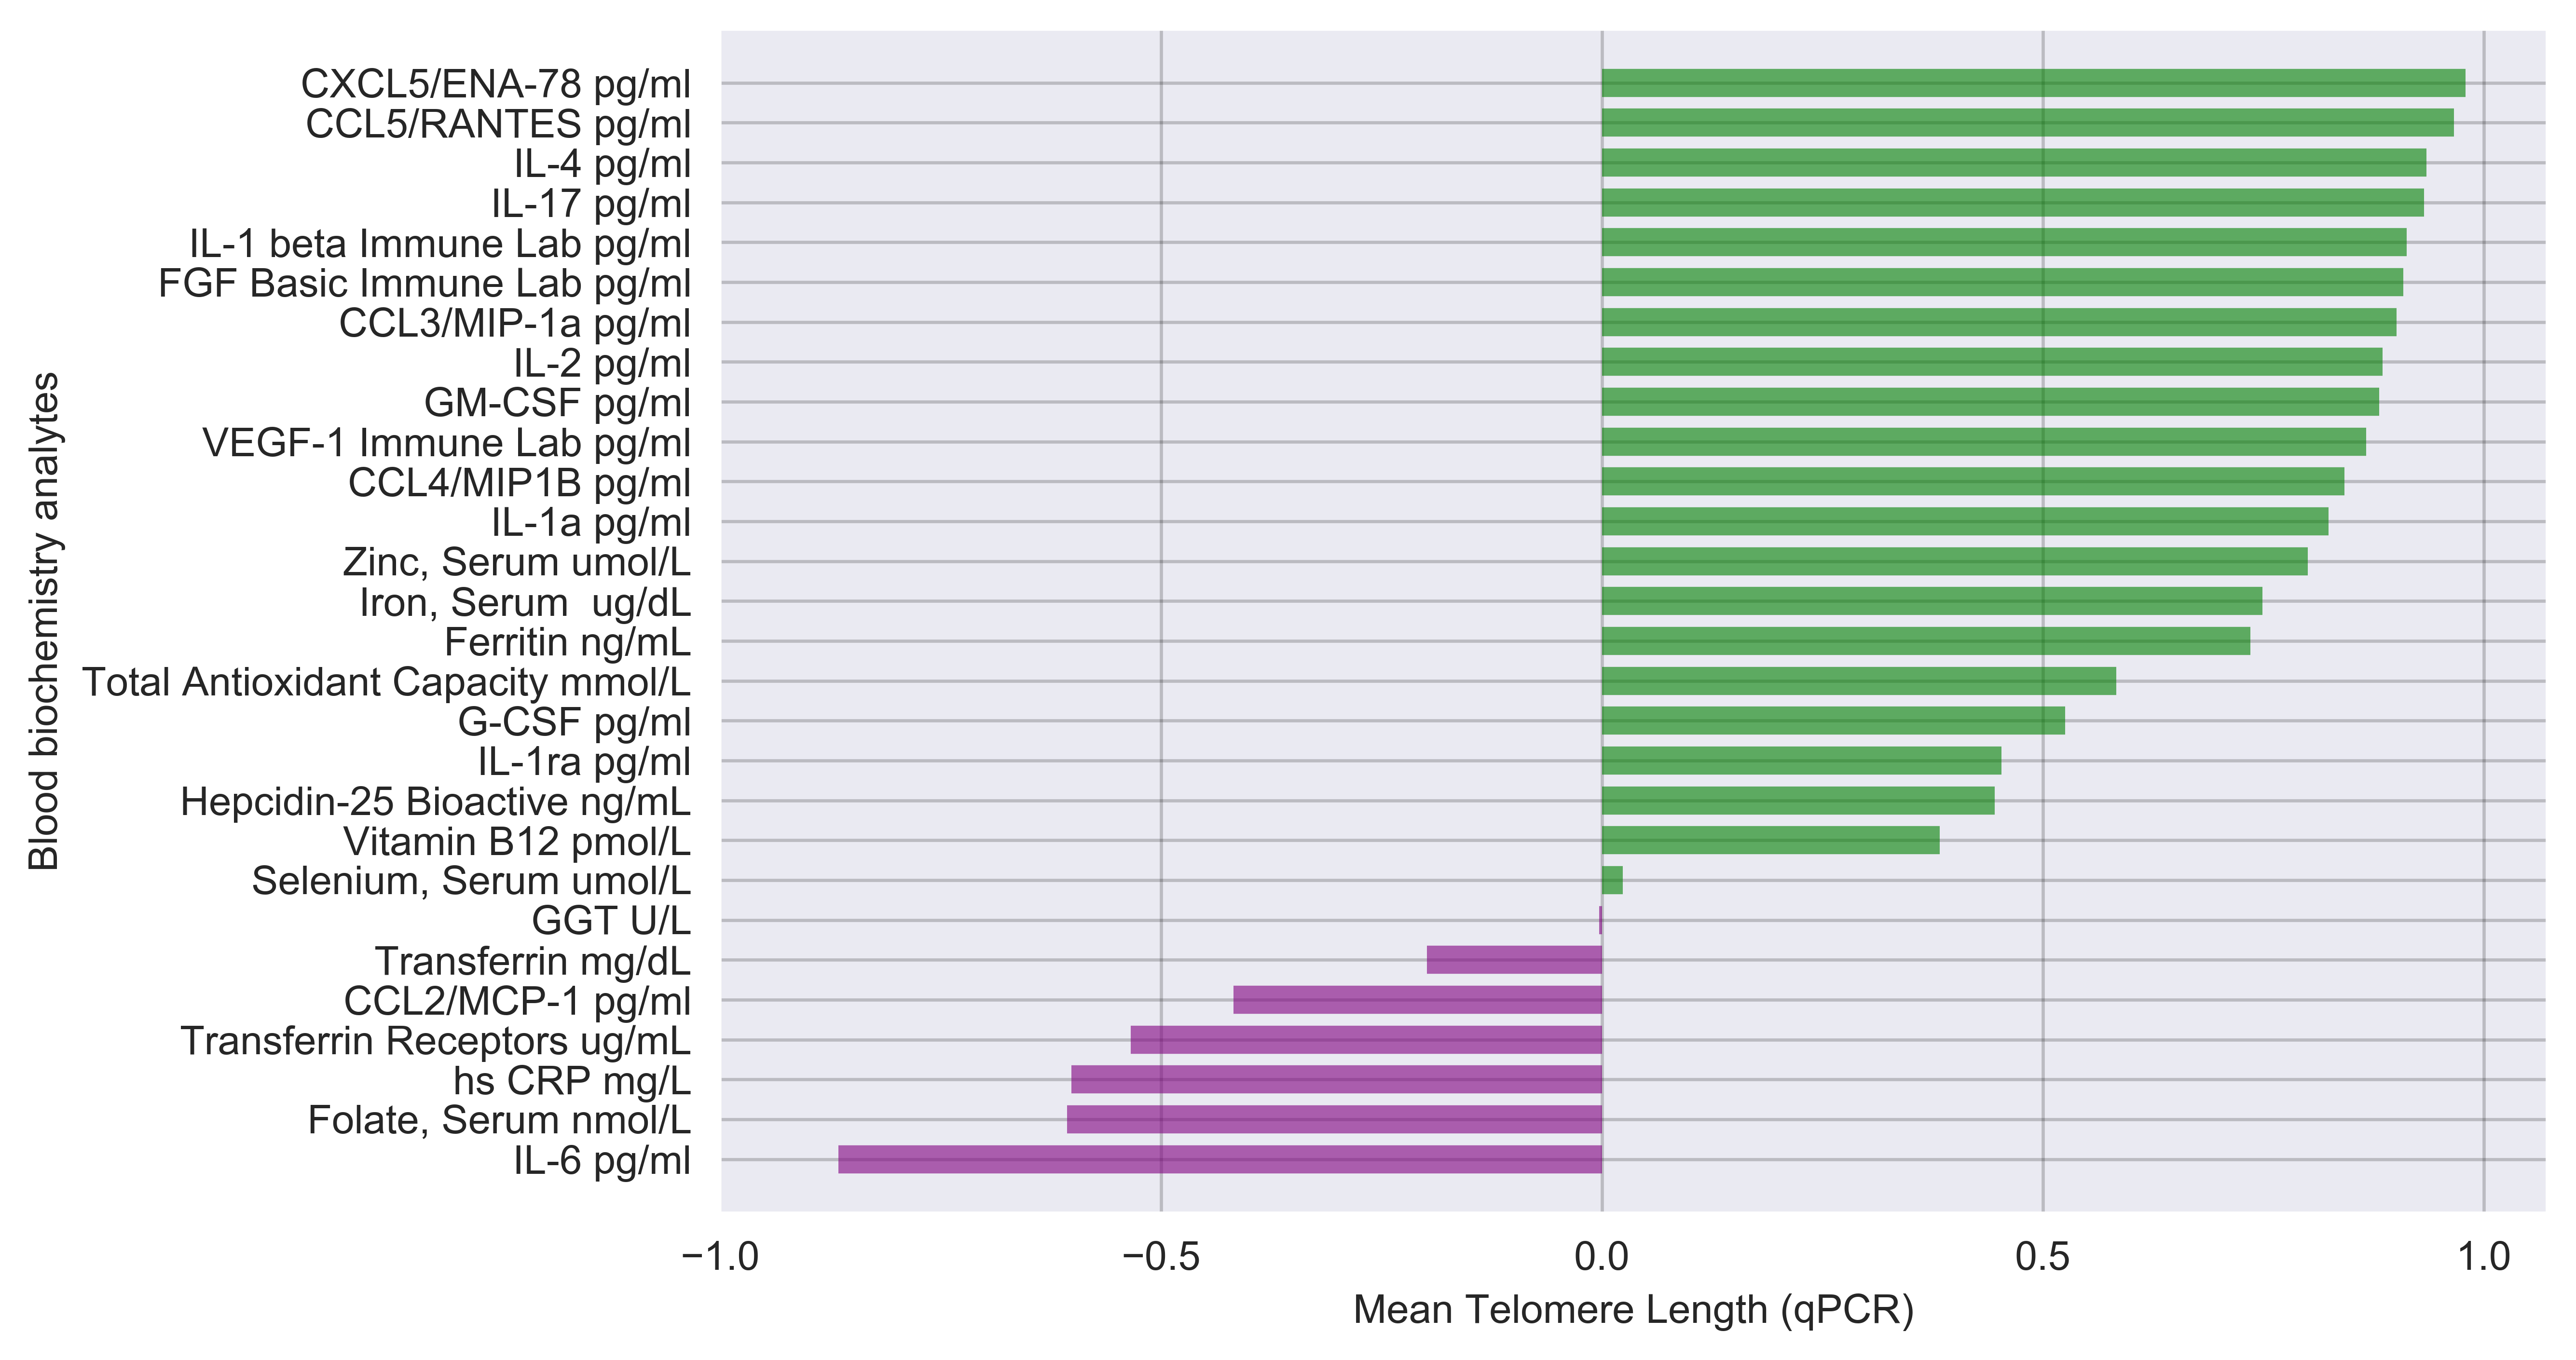

In [7]:
# mean telomere length (qPCR) ALL blood analytes

telo_ma.analyze_biochem_analytes_target(target='Mean Telomere Length (qPCR)',
                                        df=astro_telos_qpcr_grouped,
                                        melt_biochem_df=melt_blood_biochem_data,
                                        color1='green',
                                        color2='purple',
                                        abs_value_corr=0,
                                        merge_telomere_biochem_data=True,
                                        parse_correlation_values=False,
                                        fontsize=10,
                                        figsize=(9,4.8),
                                        path_labels='ALL ANALYTES',
                                        save=True)

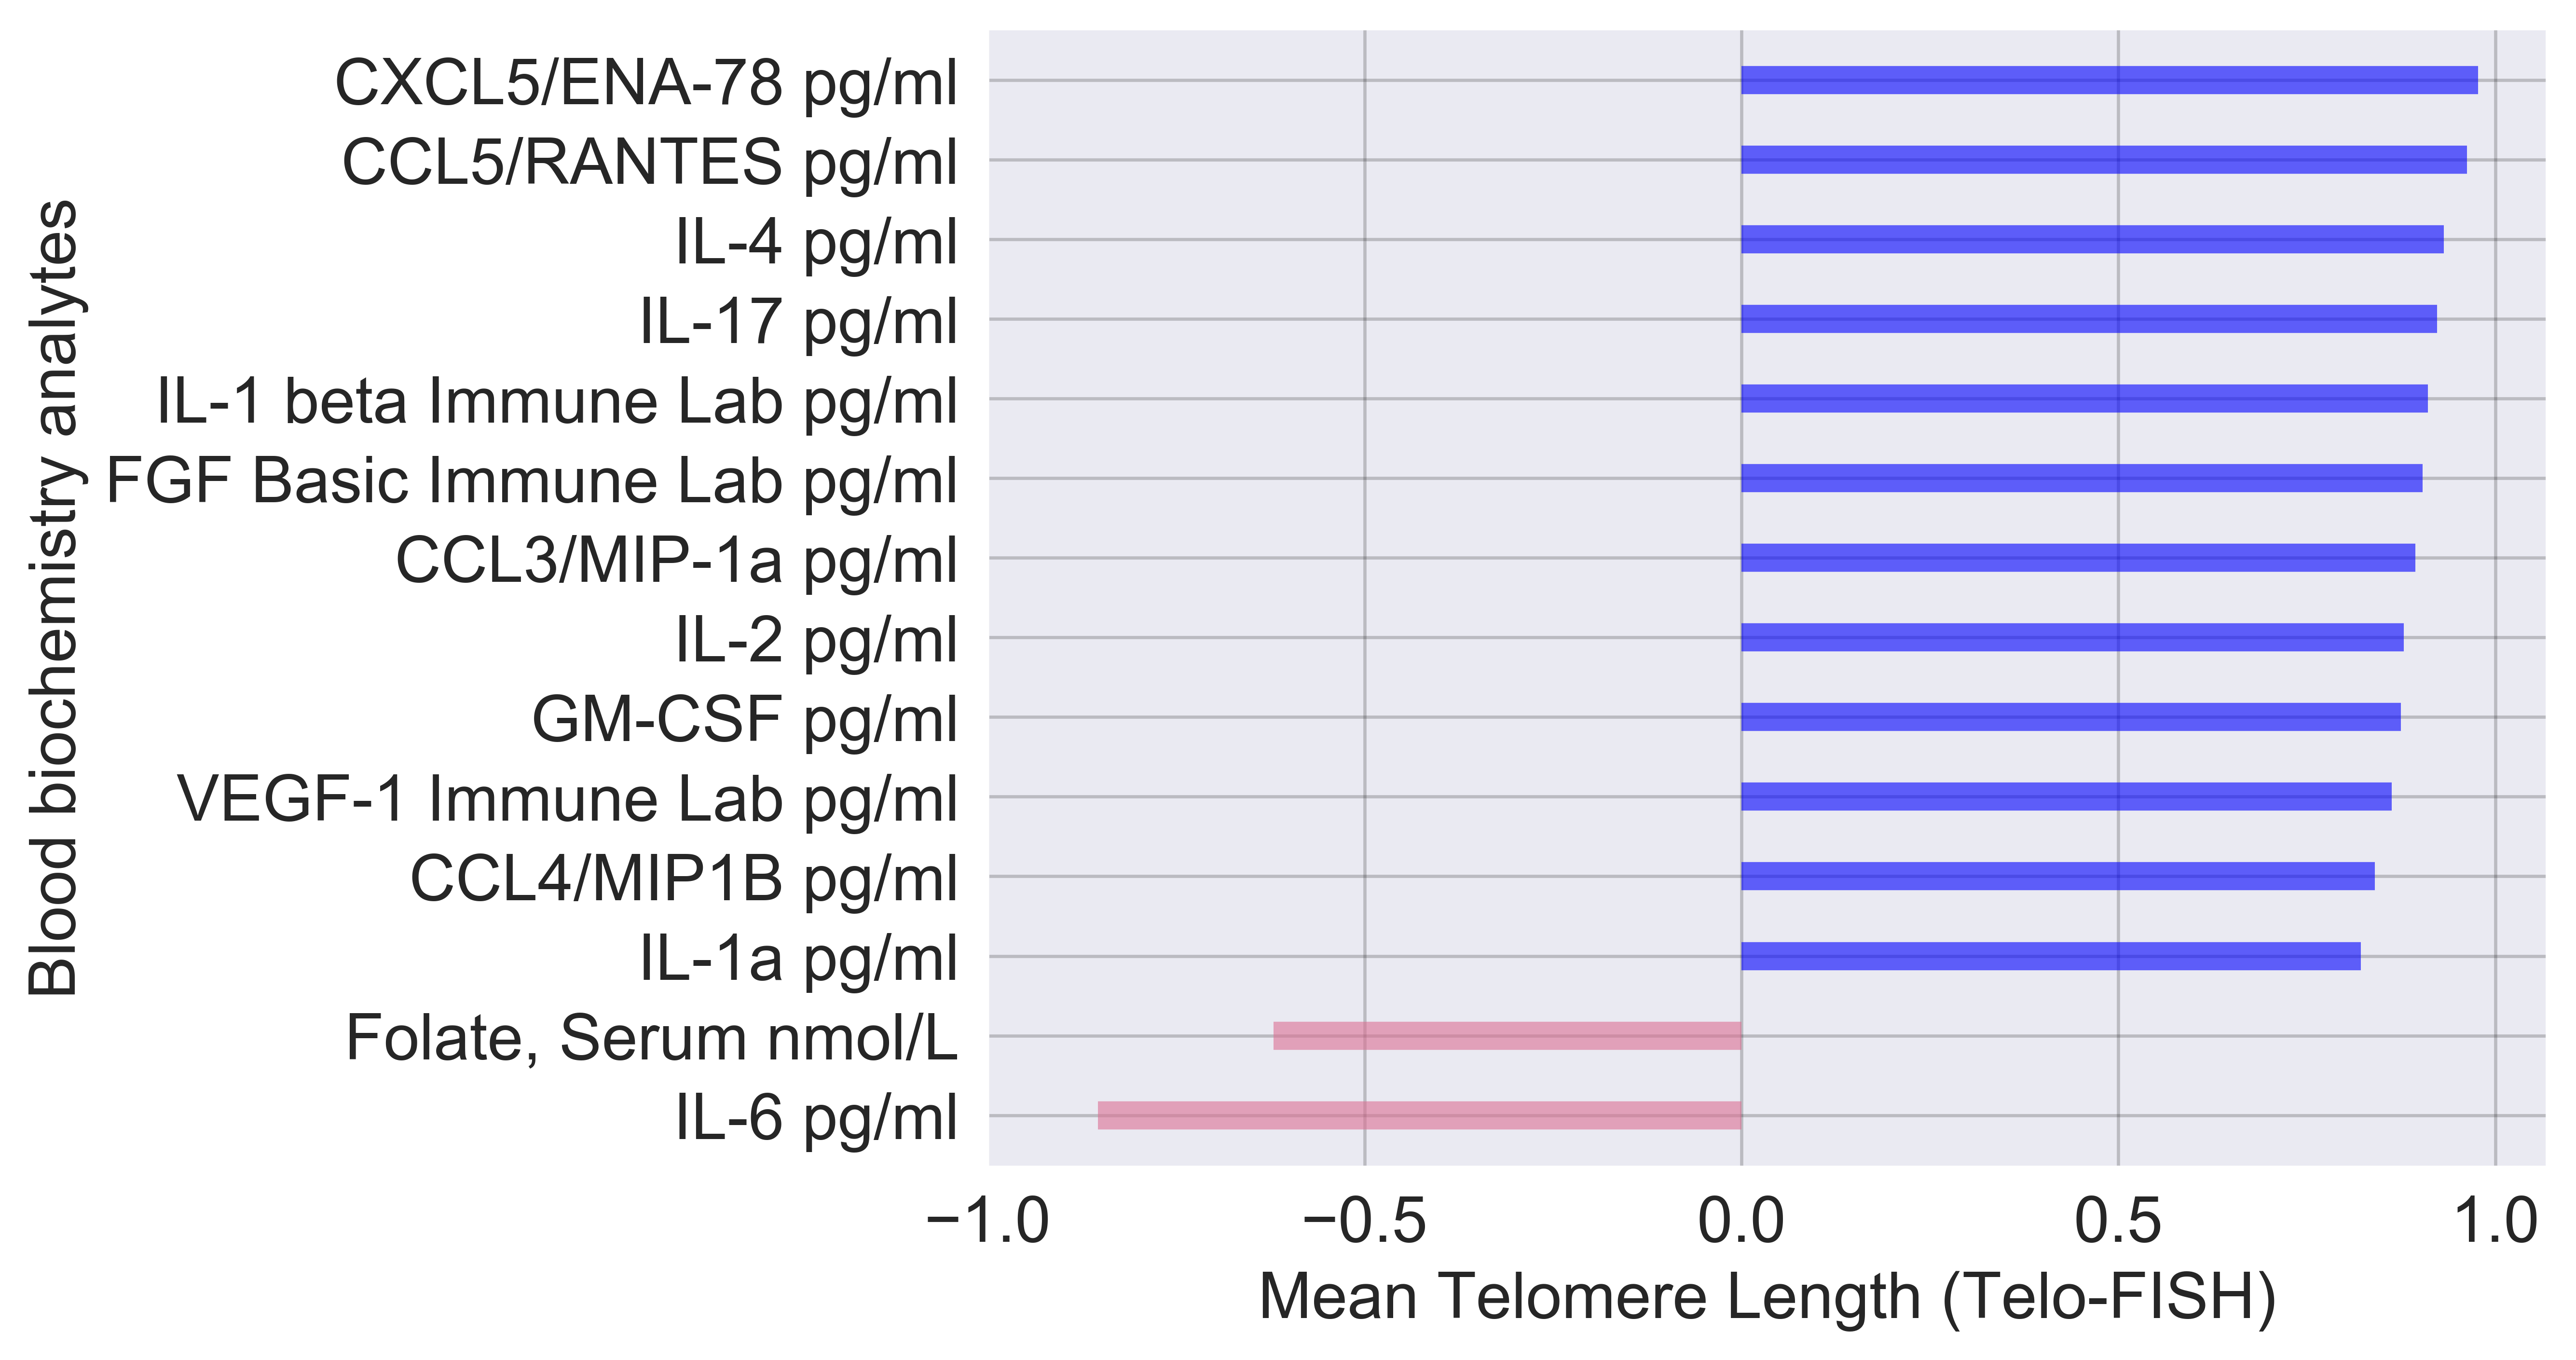

In [675]:
# mean telomere length (Telo-FISH) HIGH CORR blood analytes

telo_ma.analyze_biochem_analytes_target(target='Mean Telomere Length (Telo-FISH)',
                                        df=astro_telofish_grouped,
                                        melt_biochem_df=melt_blood_biochem_data,
                                        color1='blue',
                                        color2='palevioletred',
                                        abs_value_corr=0.6,
                                        merge_telomere_biochem_data=True,
                                        parse_correlation_values=True,
                                        parse_corr_min=0,
                                        parse_corr_max=0.8,
                                        figsize=(9,4.8))

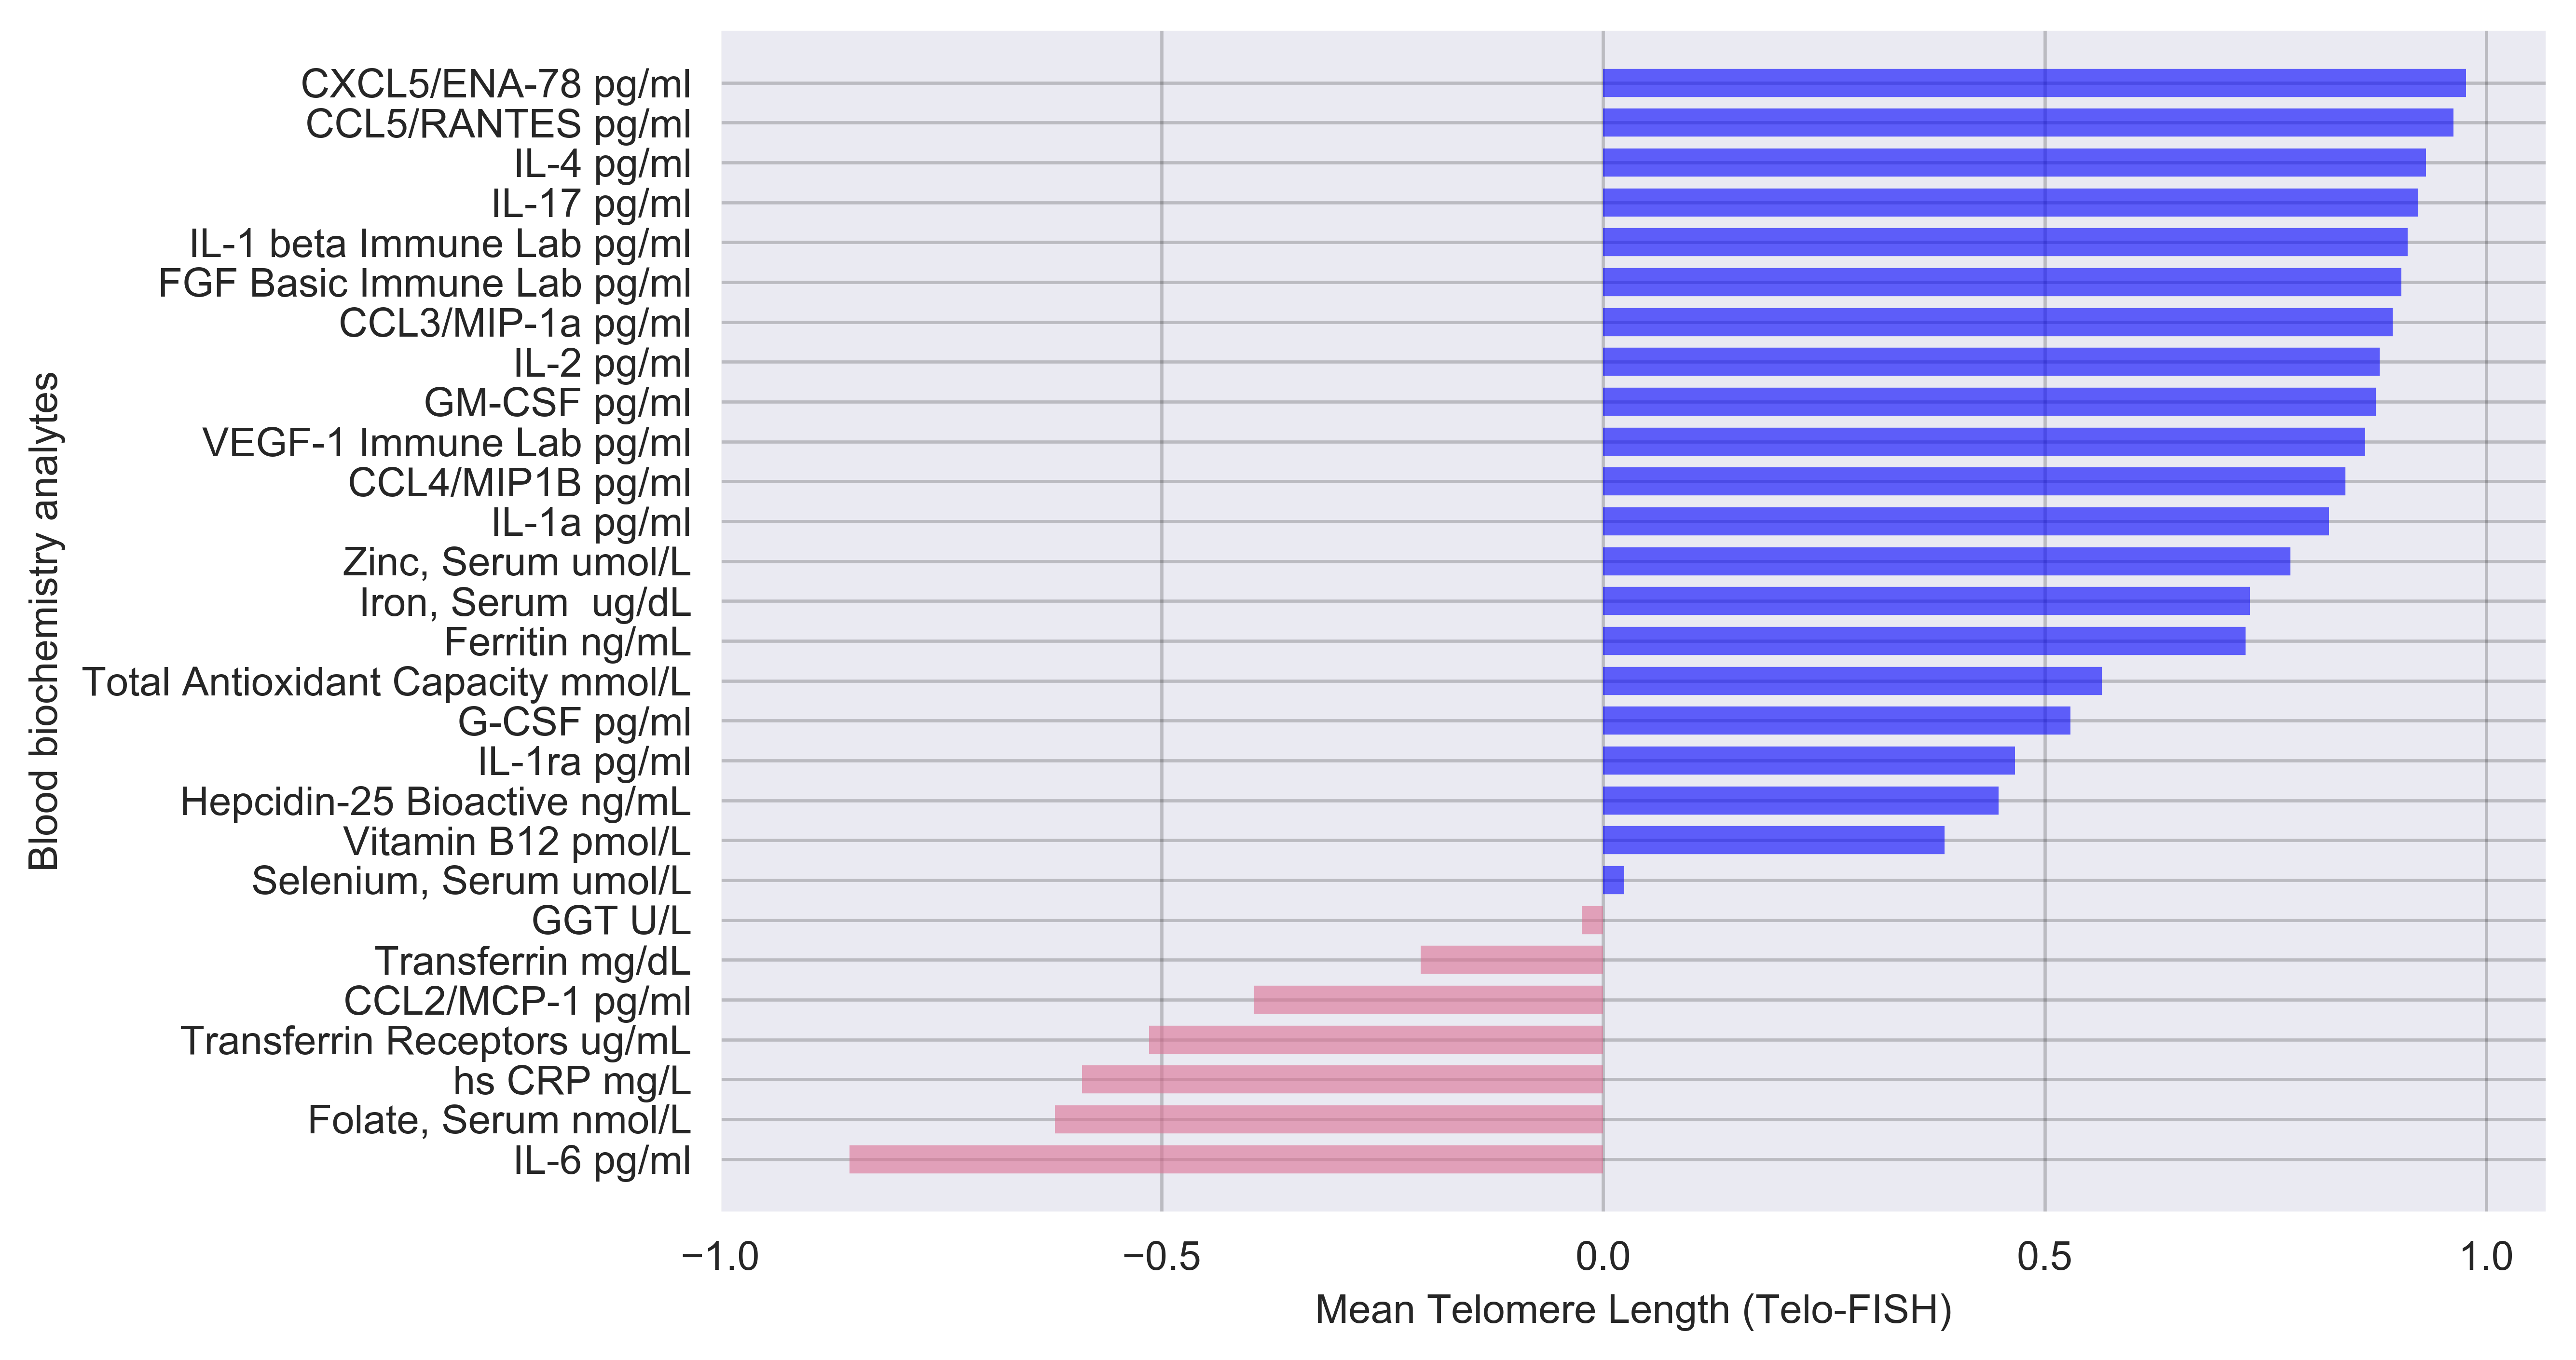

In [676]:
# mean telomere length (Telo-FISH) ALL blood analytes

telo_ma.analyze_biochem_analytes_target(target='Mean Telomere Length (Telo-FISH)',
                                        df=astro_telofish_grouped,
                                        melt_biochem_df=melt_blood_biochem_data,
                                        color1='blue',
                                        color2='palevioletred',
                                        abs_value_corr=0,
                                        merge_telomere_biochem_data=True,
                                        parse_correlation_values=False,
                                        fontsize=10,
                                        path_labels='ALL analytes',
                                        figsize=(9,4.8))

## Plotting example longitudinal correlations

### qPCR & analyte w/ highest positive corr 

In [704]:
melt_blood_biochem_data = pd.read_csv('../data/compiled and processed data/melt_blood_biochem_data.csv')

merged_df = telo_ma.correlate_astro_analytes_telomeres_pipeline(analyte_df=melt_blood_biochem_data, 
                                                                telomere_df=astro_telos_qpcr_grouped, 
                                                                target=target, astro_ids_of_interest='all astros',
                                                                how_drop_missing='by melted row', 
                                                                retain_what_flight_status='require at least one per status',
                                                                telos_percent_change='no')

In [705]:
merged_df_pivot = merged_df.pivot_table(index=['timepoint', 'Mean Telomere Length (qPCR)'], 
                                        columns='biochemistry analyte', 
                                        values='measured analyte').reset_index()

merged_df_pivot = telo_ma.set_categories_sort(telomere_df=merged_df_pivot, time='timepoint', 
                                              sort_list=['Pre', 'FD15', 'FD30', 'FD60', 'FD120', 'FD180', 'R+0', 'R+180'])

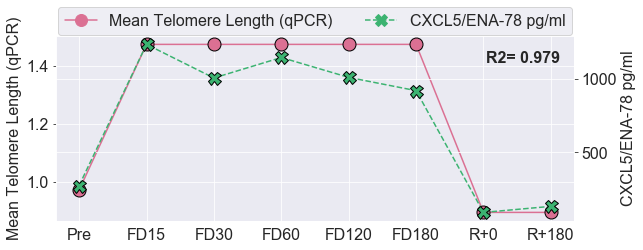

In [706]:
telo_ma.graph_biochem_analyte_data(plot_left_y='Mean Telomere Length (qPCR)', plot_right_y='CXCL5/ENA-78 pg/ml',
                                   left_y_name='Mean Telomere Length (qPCR)', right_y_name='CXCL5/ENA-78 pg/ml',
                                   ax_color1='palevioletred', ax_color2='mediumseagreen',
                                   alpha_c1=1, alpha_c2=1,
                                   fsize=(9.3, 3.4),
                                   time='timepoint', df=merged_df_pivot,
                                   bbox_to_anchor=(0.5, 1.2), handlelength=None,
                                   markerscale=2, save=True)

### Telo-FISH & analyte w/ highest positive corr 

In [678]:
melt_blood_biochem_data = pd.read_csv('../data/compiled and processed data/melt_blood_biochem_data.csv')

merged_df = telo_ma.correlate_astro_analytes_telomeres_pipeline(analyte_df=melt_blood_biochem_data, 
                                                                telomere_df=astro_telofish_grouped, 
                                                                target=target, astro_ids_of_interest='all astros',
                                                                how_drop_missing='by melted row', 
                                                                retain_what_flight_status='require at least one per status',
                                                                telos_percent_change='no')

In [679]:
merged_df_pivot = merged_df.pivot_table(index=['timepoint', 'Mean Telomere Length (Telo-FISH)'], 
                                        columns='biochemistry analyte', 
                                        values='measured analyte').reset_index()

merged_df_pivot = telo_ma.set_categories_sort(telomere_df=merged_df_pivot, time='timepoint', 
                                              sort_list=['Pre', 'FD15', 'FD30', 'FD60', 'FD120', 'FD180', 'R+0', 'R+180'])

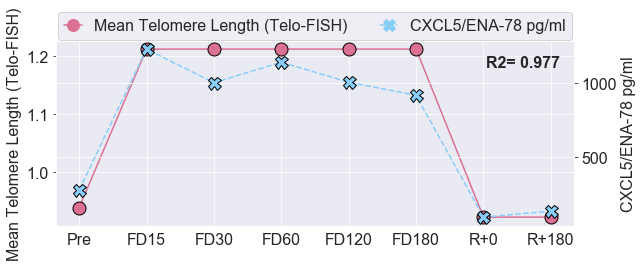

In [537]:
telo_ma.graph_biochem_analyte_data(plot_left_y='Mean Telomere Length (Telo-FISH)', plot_right_y='CXCL5/ENA-78 pg/ml',
                                   left_y_name='Mean Telomere Length (Telo-FISH)', right_y_name='CXCL5/ENA-78 pg/ml',
                                   ax_color1='palevioletred', ax_color2='lightskyblue',
                                   alpha_c1=1, alpha_c2=1,
                                   fsize=(9.3, 3.4),
                                   time='timepoint', df=merged_df_pivot,
                                   bbox_to_anchor=(0.5, 1.2), handlelength=1.1,
                                   markerscale=2, save=True)

## Urine analyte and mean telomere length (qPCR/Telo-FISH) correlations

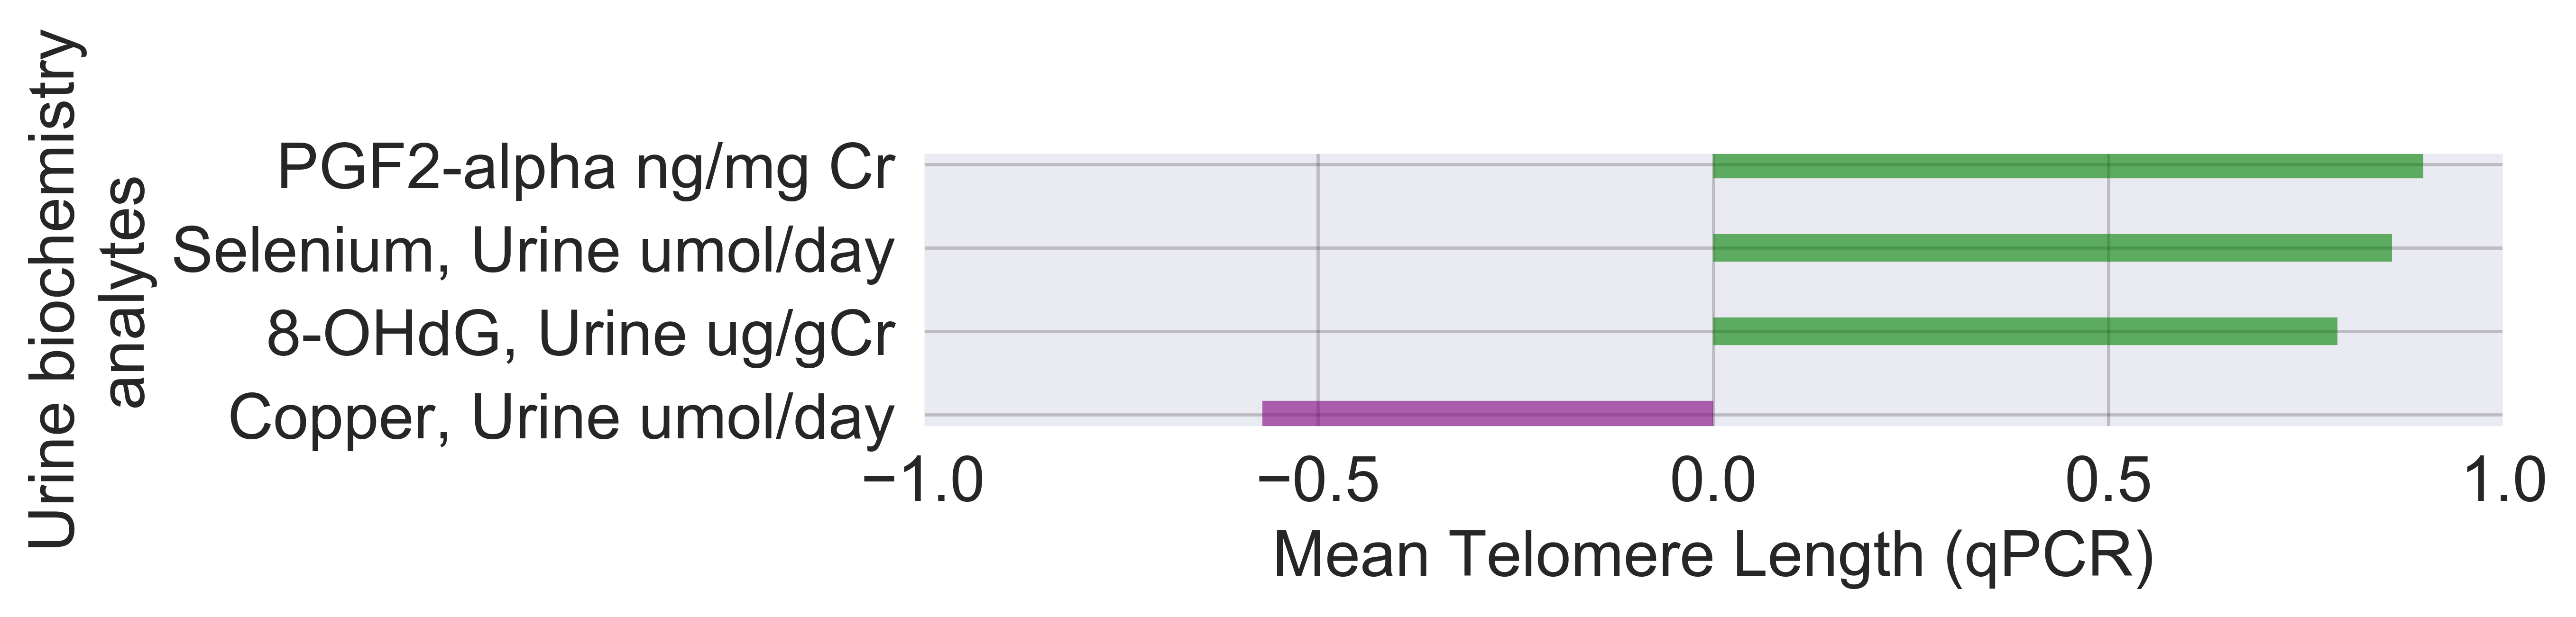

In [10]:
# mean telomere length (qPCR) urine analytes
melt_urine_biochem_data = pd.read_csv('../data/compiled and processed data/melt_urine_biochem_data.csv')

df = (astro_telos_qpcr_grouped.groupby(['flight status'])
                              .agg('mean')
                              .reset_index()
                              .drop(['astro number'], axis=1))

biochem_df = melt_urine_biochem_data.copy()
biochem_df.drop(['measurement'], axis=1, inplace=True)
merge_biochem = biochem_df.merge(df, on=['flight status'])
merge_biochem.drop(['sample type', 'timepoint'], axis=1, inplace=True)

telo_ma.analyze_biochem_analytes_target(target='Mean Telomere Length (qPCR)',
                                        df=merge_biochem,
                                        color1='green',
                                        color2='purple',
                                        abs_value_corr=0,
                                        merge_telomere_biochem_data=False,
                                        parse_correlation_values=False,
                                        y_label_name='Urine biochemistry\nanalytes',
                                        figsize=(9,2))

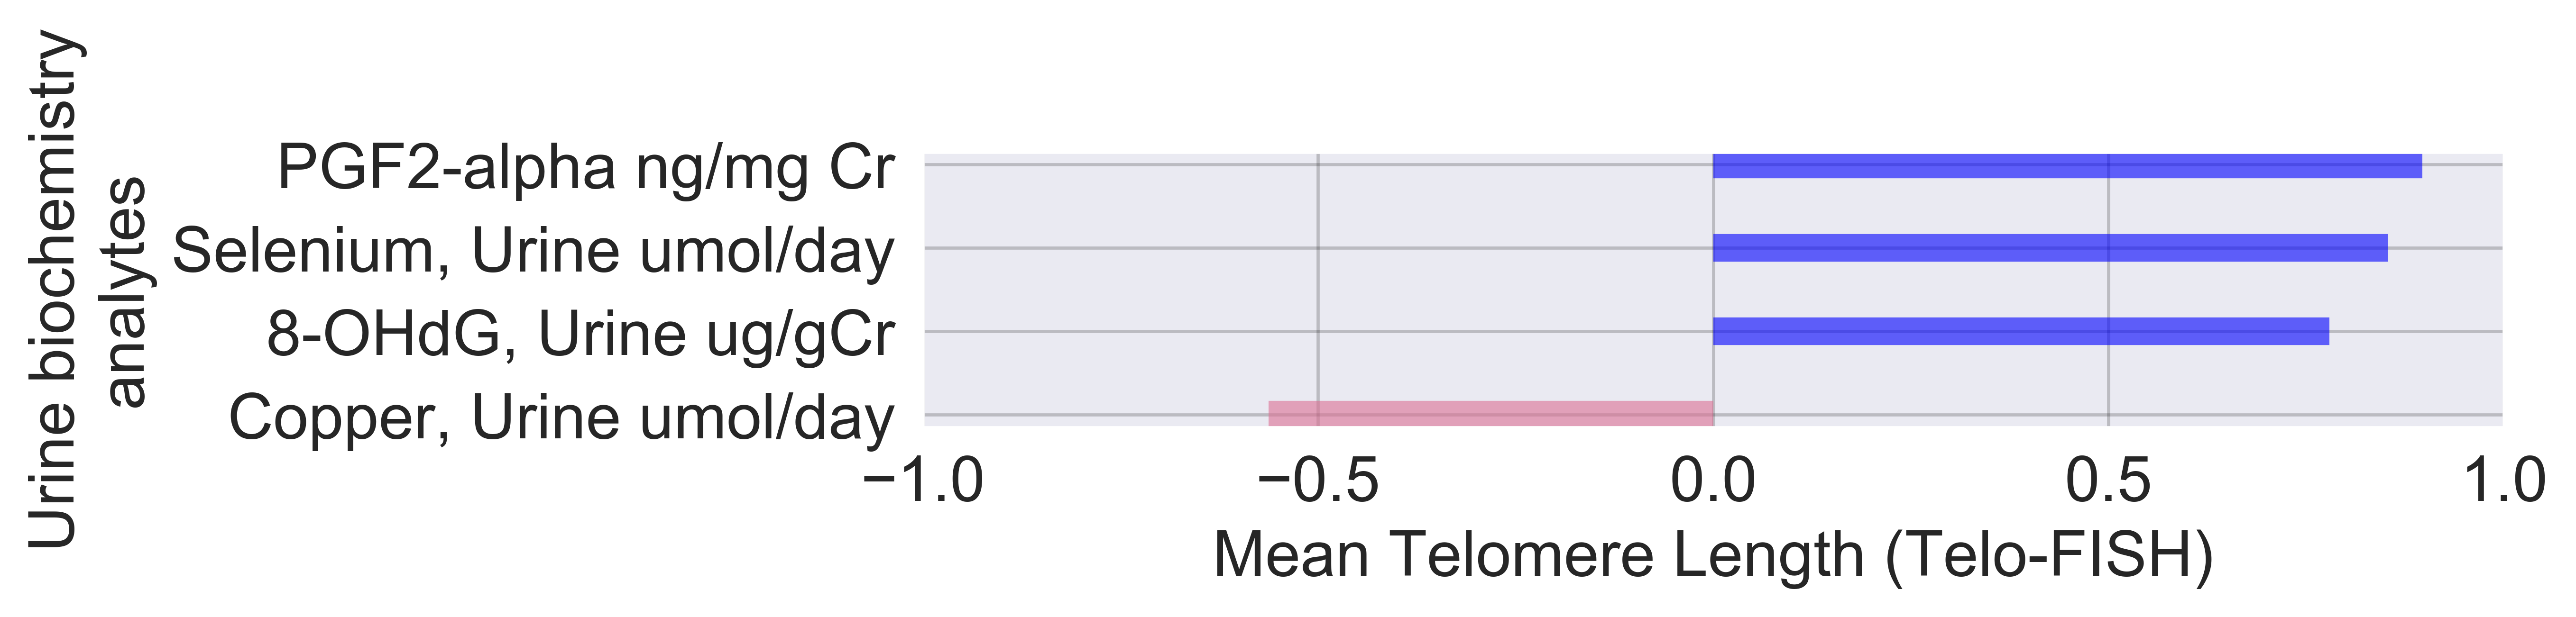

In [684]:
# mean telomere length (Telo-FISH) urine analytes
melt_urine_biochem_data = pd.read_csv('../data/compiled and processed data/melt_urine_biochem_data.csv')

df = (astro_telofish_grouped.groupby(['flight status'])
                            .agg('mean')
                            .reset_index()
                            .drop(['telo data per cell', 'astro number'], axis=1))

biochem_df = melt_urine_biochem_data.copy()
biochem_df.drop(['measurement'], axis=1, inplace=True)
merge_biochem = biochem_df.merge(df, on=['flight status'])
merge_biochem.drop(['sample type', 'timepoint'], axis=1, inplace=True)

telo_ma.analyze_biochem_analytes_target(target='Mean Telomere Length (Telo-FISH)',
                                        df=merge_biochem,
                                        color1='blue',
                                        color2='palevioletred',
                                        abs_value_corr=0,
                                        merge_telomere_biochem_data=False,
                                        parse_correlation_values=False,
                                        y_label_name='Urine biochemistry\nanalytes',
                                        figsize=(9,2))

# Clustering/correlating inversions with biochemical data

## Clustering 11 astros by inversions (flight status)

In [289]:
aberr_df = telo_ma.pull_aberr_df()

aberr_df['flight status'] = aberr_df['flight status'].astype('str')
invs = aberr_df[['astro id', 'flight status', 'inversions']].copy()
invs = invs[invs['flight status'] != 'Mid-Flight'].copy()

invs.columns.name = ''

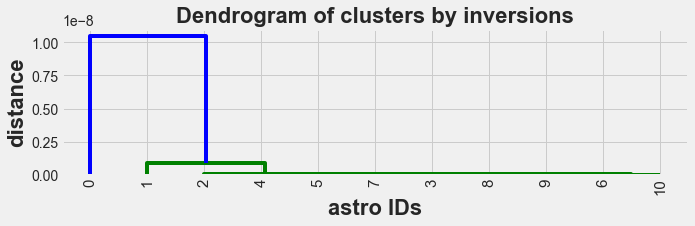

0 Cluster number 2 has 1 elements
1 Cluster number 1 has 10 elements


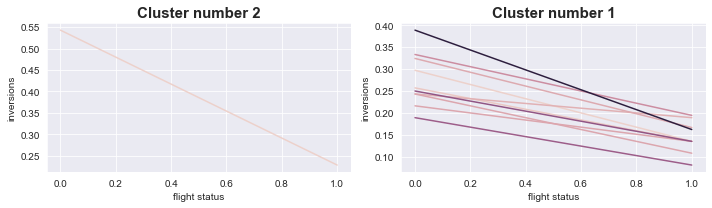

In [290]:
clustered_invs = telo_ma.cluster_data_return_df(invs, 'inversions', time='flight status', cut_off_n=2, 
                                                verbose=True, y_size=3, x_size=10)

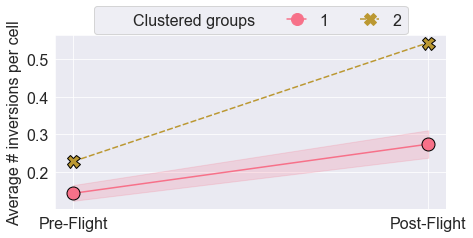

In [291]:
clustered_invs.rename({'inversions cluster groups': 'Clustered groups'}, axis=1, inplace=True)
clustered_invs['flight status'] = clustered_invs['flight status'].astype('category')
clustered_invs['flight status'].cat.reorder_categories(['Pre-Flight', 'Post-Flight'], inplace=True)

telo_ma.graph_cluster_groups(clustered_invs, time='flight status', target='inversions', 
                             hue='Clustered groups', colors='husl', figsize=(7, 3.2),
                             n_cols=4, y_label_name='Average # inversions per cell', 
                             save=True, fontsize=16, bbox_to_anchor=(0.5, 1.21))

In [15]:
pivot = invs.pivot_table(index='astro id', columns='flight status', values='inversions')
pivot = pivot[['Pre-Flight', 'Post-Flight']].copy()

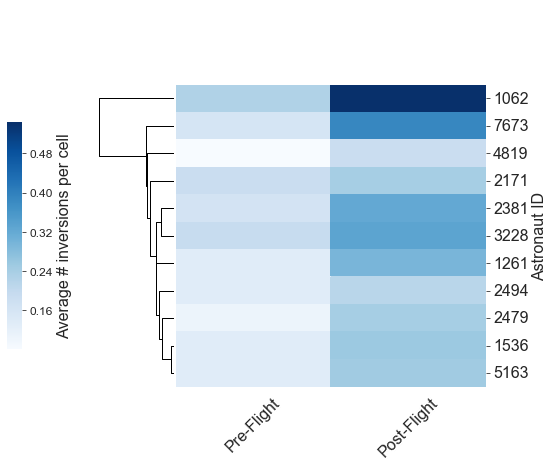

In [16]:
telo_ma.clustermap_plot(pivot, z_score=None, color_map='Blues',
                        y_label='Average # inversions per cell', 
                        metric='euclidean', save=True, fontsize=16)
# 1062 wp

## Clustering 3 astros by inversions (flight status)

In [285]:
# pulling out 3 astros
aberr_df = telo_ma.pull_aberr_df()
aberr_df['flight status'] = aberr_df['flight status'].astype('str')

invs_3 = aberr_df[['astro id', 'flight status', 'inversions']].copy()
invs_3 = invs_3[invs_3['astro id'].isin([2171, 5163, 1536])]
invs_3.columns.name = ''

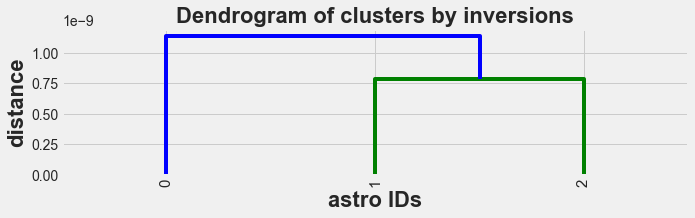

0 Cluster number 1 has 3 elements


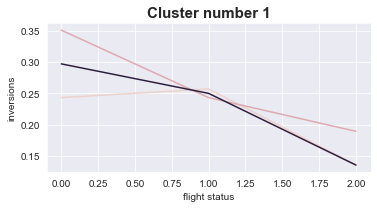

In [286]:
clustered_invs_3 = telo_ma.cluster_data_return_df(invs_3, 'inversions', time='flight status', cut_off_n=1, 
                                                  verbose=True, y_size=3, x_size=10)

In [287]:
clustered_invs_3['inversions cluster groups'] = clustered_invs_3['astro id'].apply(lambda row: 1 if row == 2171 else 2)

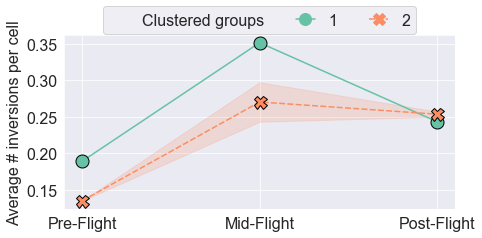

In [288]:
clustered_invs_3.rename({'inversions cluster groups': 'Clustered groups'}, axis=1, inplace=True)
clustered_invs_3['flight status'] = clustered_invs_3['flight status'].astype('category')
clustered_invs_3['flight status'].cat.reorder_categories(['Pre-Flight', 'Mid-Flight', 'Post-Flight'], inplace=True)

telo_ma.graph_cluster_groups(clustered_invs_3, time='flight status', target='inversions', 
                             hue='Clustered groups', colors='Set2', figsize=(7, 3.2),
                             n_cols=4, y_label_name='Average # inversions per cell', 
                             save=True, fontsize=16, 
                             bbox_to_anchor=(0.5, 1.21),
                             path_labels='3 astros')

In [21]:
pivot_3 = invs_3.pivot_table(index='astro id', columns='flight status', values='inversions')
pivot_3 = pivot_3[['Pre-Flight', 'Mid-Flight', 'Post-Flight']].copy()

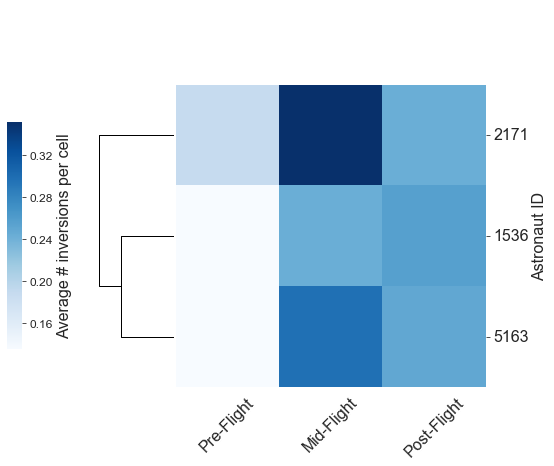

In [22]:
telo_ma.clustermap_plot(pivot_3, z_score=None, color_map='Blues',
                        y_label='Average # inversions per cell', 
                        metric='euclidean', save=True, fontsize=16,
                        path_labels='3 astros')

## Correlating inversions biochemical analytes

### Blood

In [685]:
import importlib
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


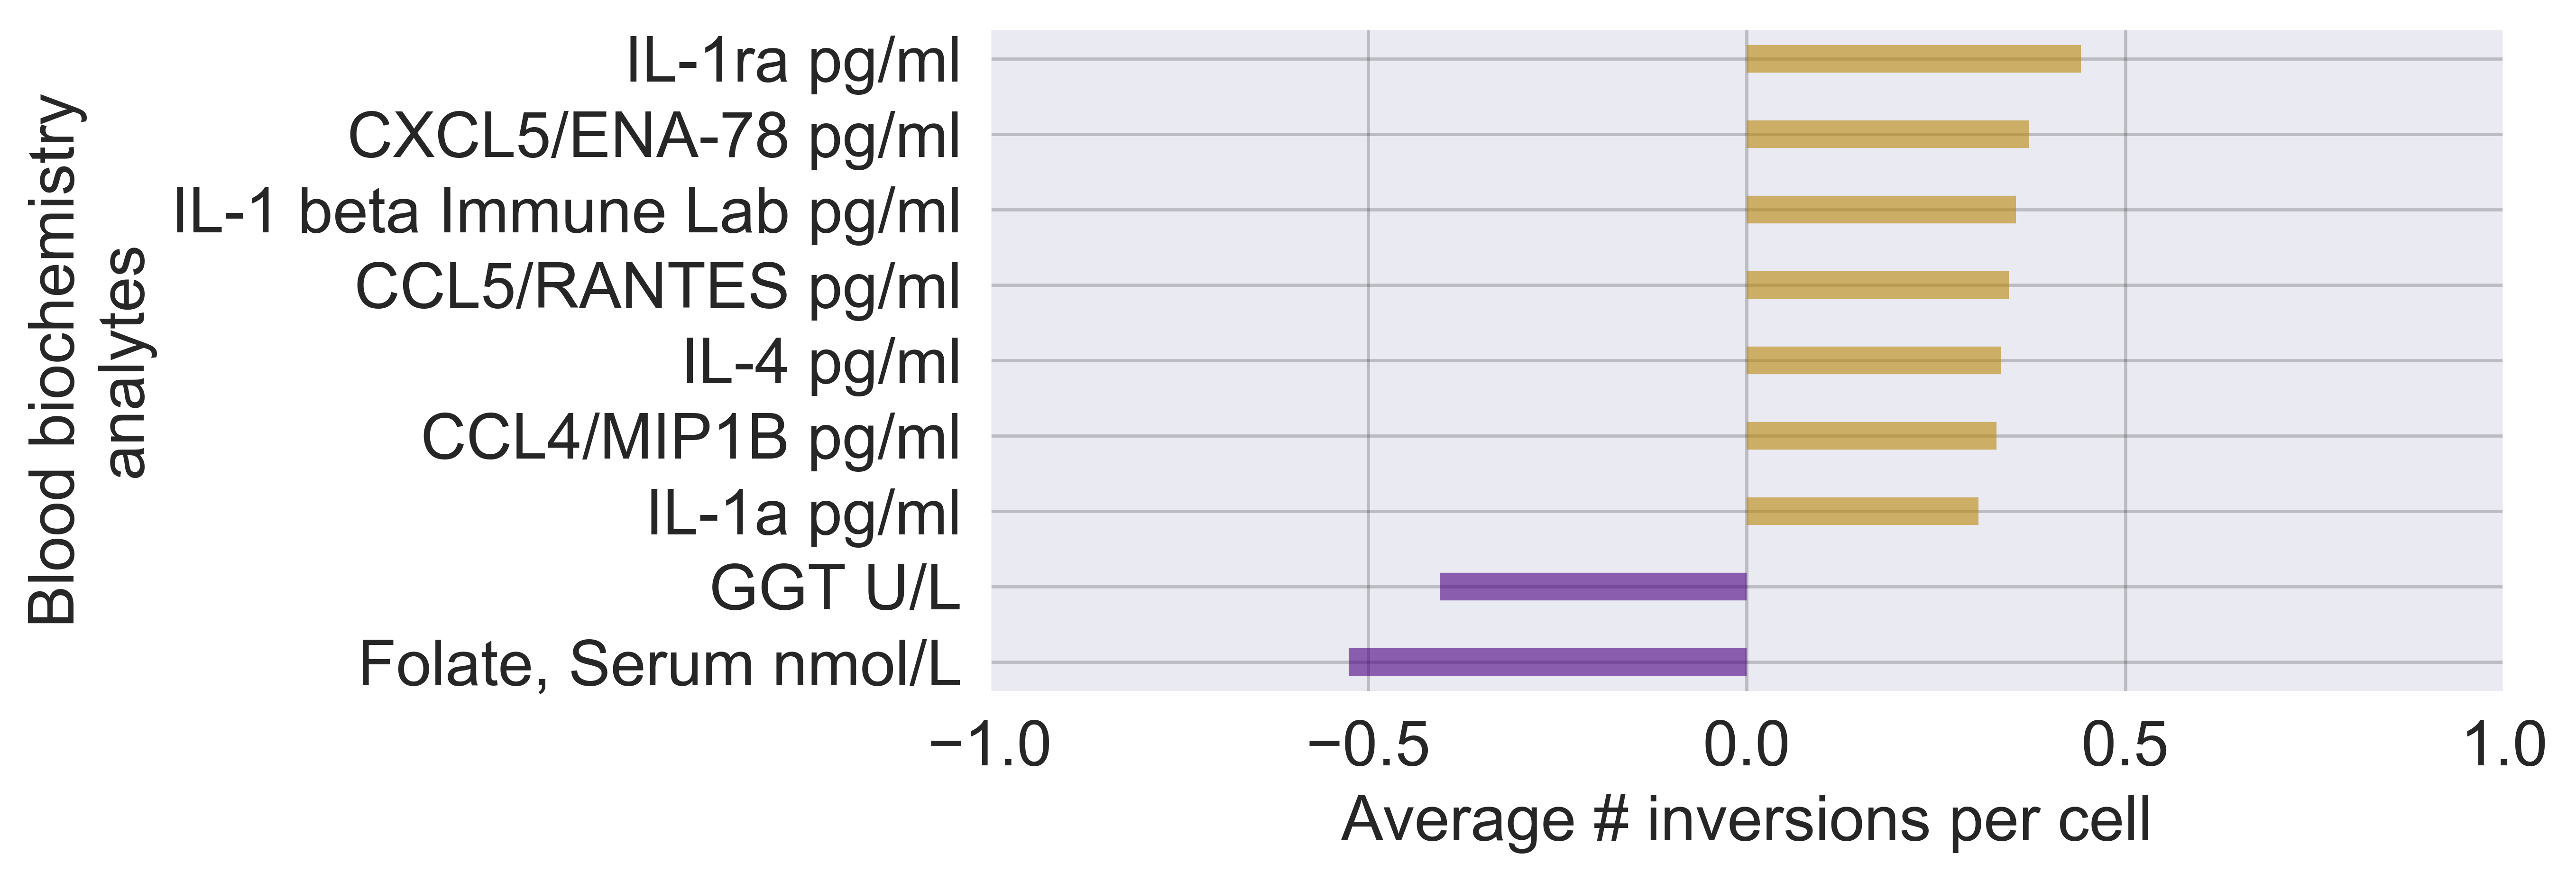

In [694]:
# average num inversions & HIGH CORR blood biochem data 
melt_blood_biochem_data = pd.read_csv('../data/compiled and processed data/melt_blood_biochem_data.csv')

inv_df = aberr_df[['astro id', 'flight status', 'inversions']].copy()
inv_df.rename({'inversions':'Average # inversions per cell'}, inplace=True, axis=1)

grp_inv_df = inv_df.groupby(['flight status']).agg('mean').reset_index().drop(['astro id'], axis=1)

biochem_df = melt_blood_biochem_data.copy()
biochem_df.drop(['measurement'], axis=1, inplace=True)
merge_biochem_inv = biochem_df.merge(grp_inv_df, on=['flight status'])

telo_ma.analyze_biochem_analytes_target(target='Average # inversions per cell',
                                        df=grp_inv_df,
                                        melt_biochem_df=biochem_df,
                                        color1='darkgoldenrod',
                                        color2='indigo',
                                        abs_value_corr=0.3,
                                        merge_telomere_biochem_data=True,
                                        parse_correlation_values=False,
                                        y_label_name='Blood biochemistry\nanalytes',
                                        figsize=(9,3.2),
                                        save=True)

In [695]:
merged_df_pivot = merge_biochem_inv.pivot_table(index=['timepoint', 'Average # inversions per cell'], 
                                                columns='biochemistry analyte', 
                                                values='measured analyte').reset_index()

merged_df_pivot = telo_ma.set_categories_sort(telomere_df=merged_df_pivot, time='timepoint', 
                                              sort_list=['Pre', 'FD15', 'FD30', 'FD60', 'FD120', 'FD180', 'R+0', 'R+180'])

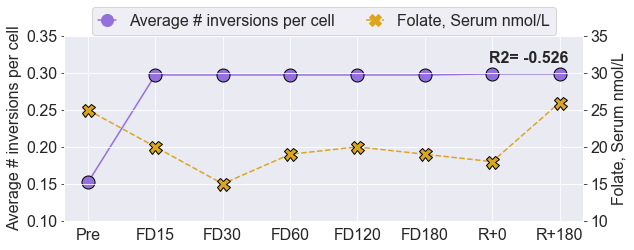

In [700]:
telo_ma.graph_biochem_analyte_data(plot_left_y='Average # inversions per cell', plot_right_y='Folate, Serum nmol/L',
                                   left_y_name='Average # inversions per cell', right_y_name='Folate, Serum nmol/L',
                                   ax_color1='mediumpurple', ax_color2='goldenrod',
                                   alpha_c1=1, alpha_c2=1,
                                   fsize=(9.3, 3.4),
                                   ylim1=(.10, .35), ylim2=(10, 35),
                                   time='timepoint', df=merged_df_pivot,
                                   bbox_to_anchor=(0.5, 1.2), handlelength=1.1,
                                   markerscale=2, save=True)

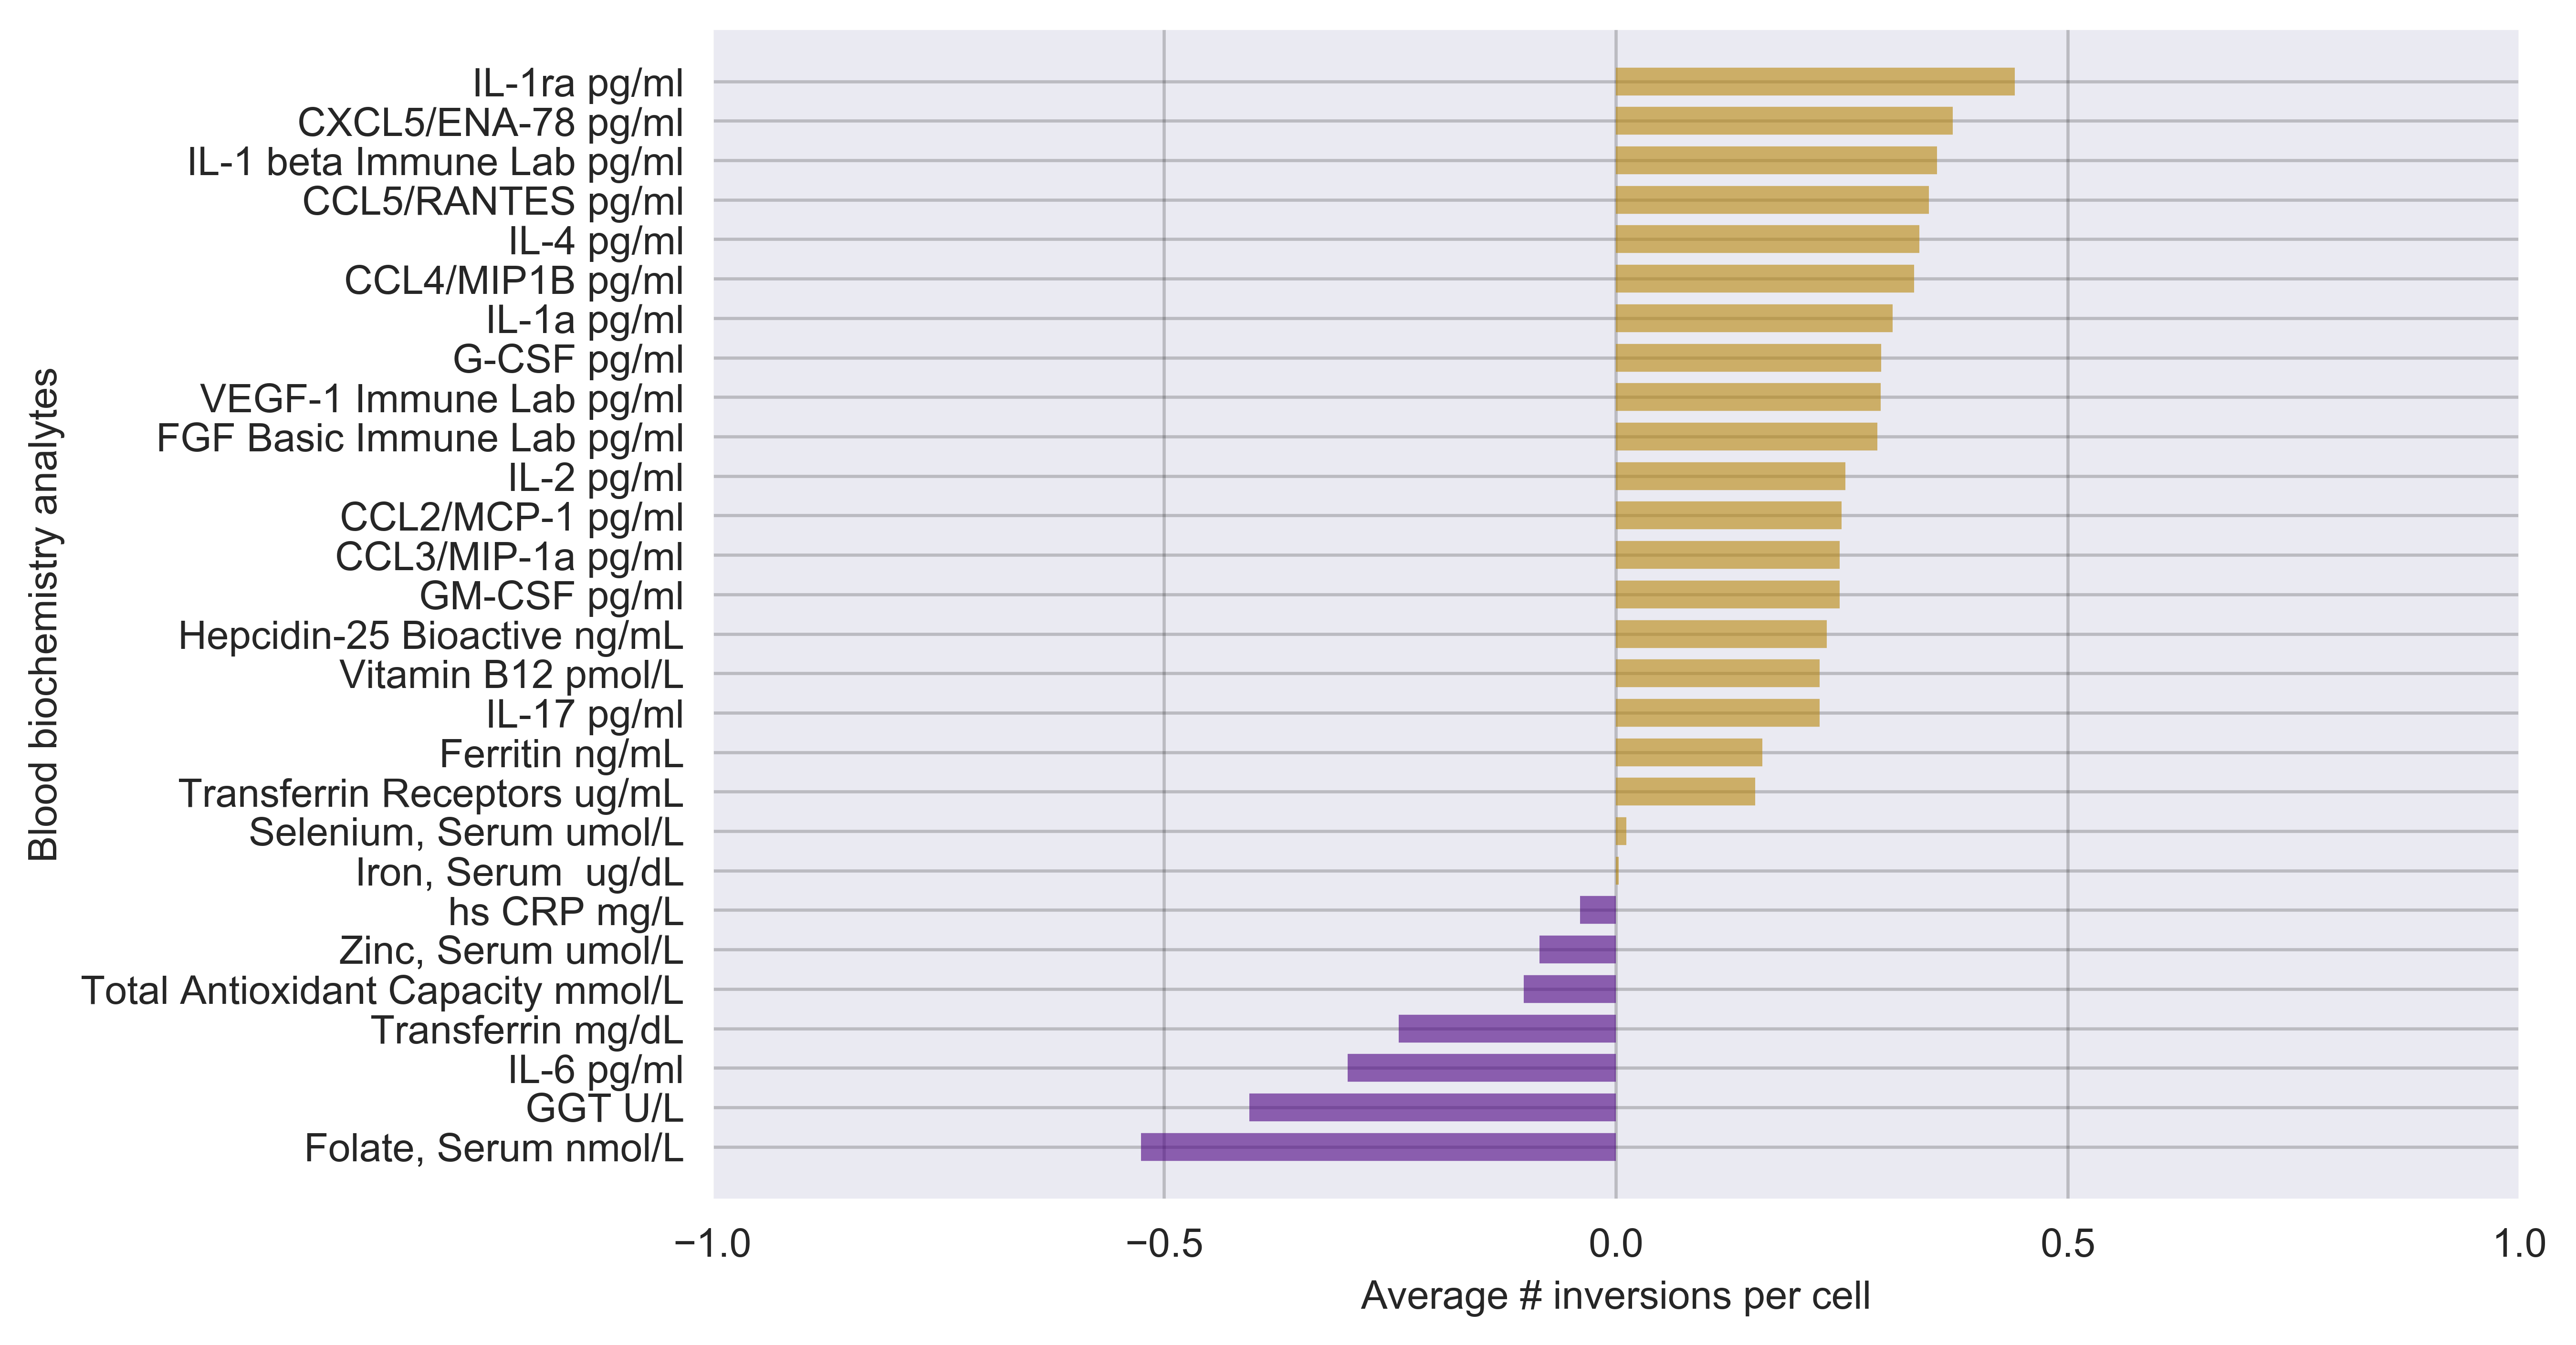

In [707]:
# average num inversions & ALL blood biochem data 
melt_blood_biochem_data = pd.read_csv('../data/compiled and processed data/melt_blood_biochem_data.csv')

inv_df = aberr_df[['astro id', 'flight status', 'inversions']].copy()
inv_df.rename({'inversions':'Average # inversions per cell'}, inplace=True, axis=1)

grp_inv_df = inv_df.groupby(['flight status']).agg('mean').reset_index().drop(['astro id'], axis=1)

biochem_df = melt_blood_biochem_data.copy()
biochem_df.drop(['measurement'], axis=1, inplace=True)
merge_biochem_inv = biochem_df.merge(grp_inv_df, on=['flight status'])

telo_ma.analyze_biochem_analytes_target(target='Average # inversions per cell',
                                        df=grp_inv_df, melt_biochem_df=biochem_df,
                                        color1='darkgoldenrod', color2='indigo',
                                        abs_value_corr=0,
                                        merge_telomere_biochem_data=True,
                                        parse_correlation_values=False,
                                        y_label_name='Blood biochemistry analytes',
                                        path_labels='ALL analytes',
                                        fontsize=10,
                                        figsize=(9,4.8),
                                        save=True)

### Urine

In [69]:
# biochem_df

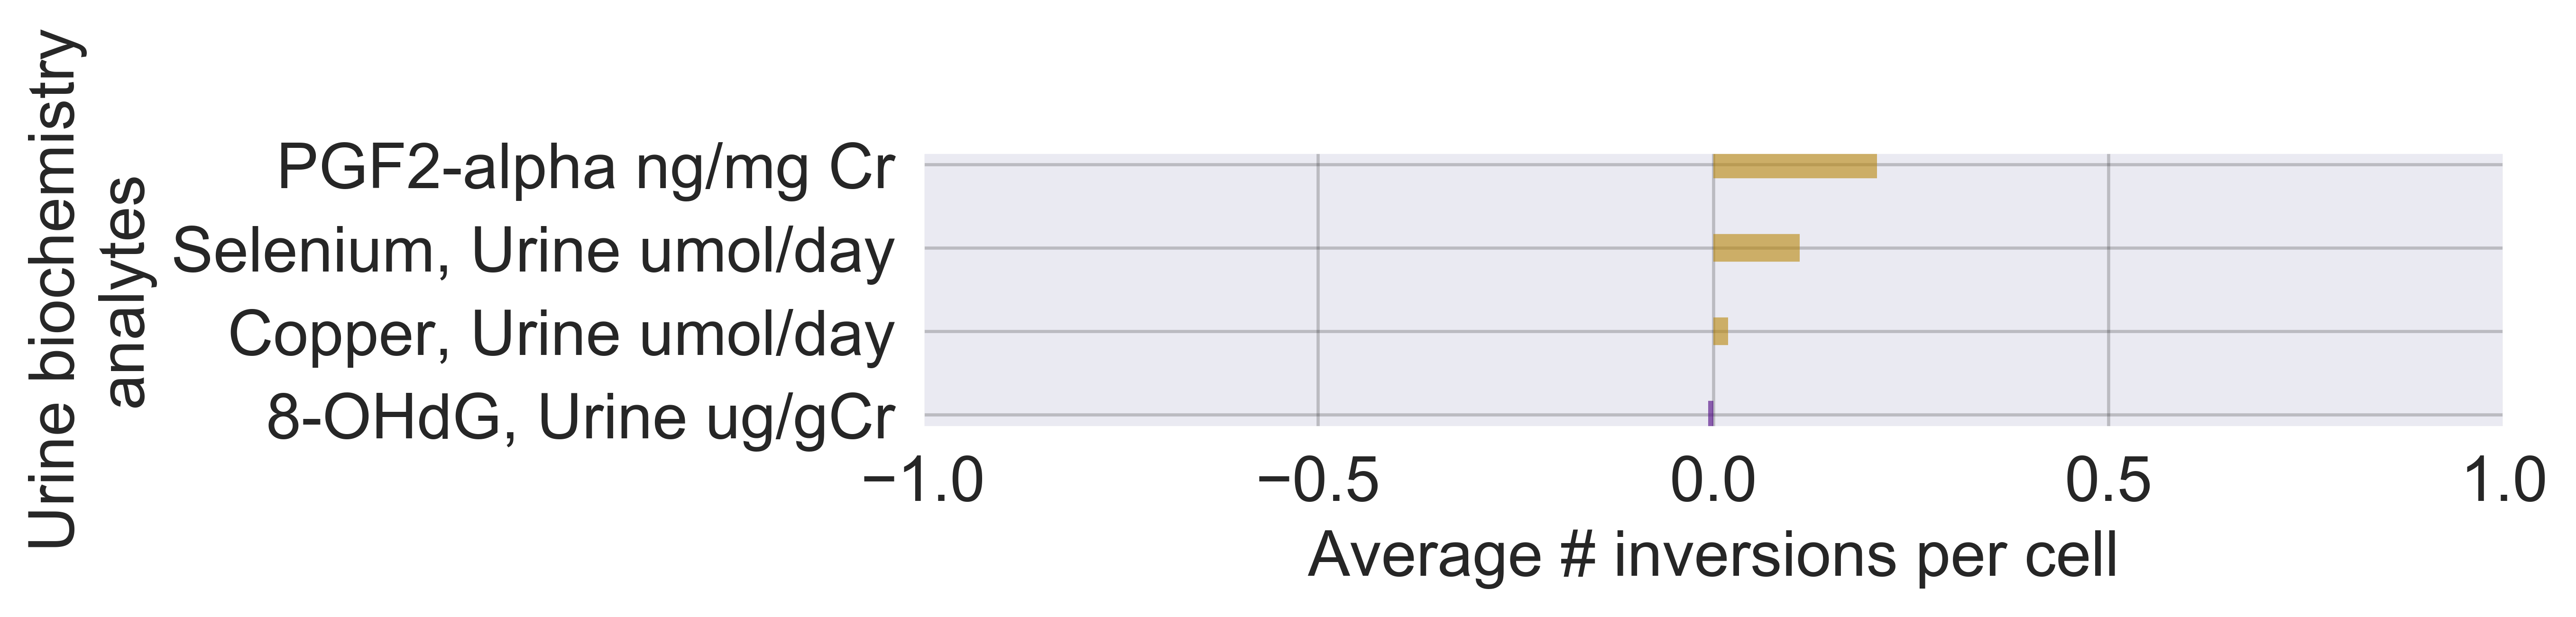

In [702]:
# average num inversions & blood biochem data 
melt_urine_biochem_data = pd.read_csv('../data/compiled and processed data/melt_urine_biochem_data.csv')

inv_df = aberr_df[['astro id', 'flight status', 'inversions']].copy()
inv_df.rename({'inversions':'Average # inversions per cell'}, inplace=True, axis=1)

grp_inv_df = inv_df.groupby(['flight status']).agg('mean').reset_index().drop(['astro id'], axis=1)

biochem_df = melt_urine_biochem_data.copy()
biochem_df.drop(['measurement', 'sample type'], axis=1, inplace=True)
merge_biochem_inv = biochem_df.merge(grp_inv_df, on=['flight status'])
merge_biochem_inv.rename({'inversions':'Average # inversions per cell'}, inplace=True, axis=1)

telo_ma.analyze_biochem_analytes_target(target='Average # inversions per cell',
                                        df=grp_inv_df,
                                        melt_biochem_df=biochem_df,
                                        color1='darkgoldenrod',
                                        color2='indigo',
                                        abs_value_corr=0,
                                        merge_telomere_biochem_data=True,
                                        parse_correlation_values=False,
                                        y_label_name='Urine biochemistry\nanalytes',
                                        figsize=(9,2),
                                        save=True)

# EDA UMAP

In [83]:
# melt_urine_biochem_data = pd.read_csv('../data/compiled and processed data/melt_urine_biochem_data.csv')

# biochem_df = melt_urine_biochem_data.copy()
# biochem_df.drop(['measurement'], axis=1, inplace=True)
# biochem_df

In [4]:
import umap

In [6]:
merged = telo_ma.pull_merge_all_data(merge_what_data=['qpcr', 'telofish', 'aberr'],
                                     how_groupby_telo_data=['astro id', 'flight status'])

merged.drop(['telo data per cell', 'astro number'], axis=1, inplace=True)

#MID-FLIGHT EXCLUDED
# merged_parse = merged.copy()
# merged_parse = merged[merged['flight status'] != 'Mid-Flight'].reset_index(drop=True).copy()
# flight_status = merged_parse[['flight status']].reset_index(drop=True)
# merged_parse['flight status'] = merged_parse['flight status'].apply(lambda row: 1 if row == 'Pre-Flight' else 2)

#MID-FLIGHT INCLUDED
flight_status = merged[['flight status']].reset_index(drop=True)
def encode_row(row):
    flight_dict={'Pre-Flight':1, 'Mid-Flight':2, 'Post-Flight':3}
    return flight_dict[row]
merged['flight status'] = merged['flight status'].apply(lambda row: encode_row(row))
merged_parse = merged.copy()

target = merged_parse[['astro id']]
features = merged_parse.drop(['astro id'], axis=1)

In [ ]:
#UMAP DIMENSIONALITY REDUCTION
reducer = umap.UMAP(random_state=3)
embeddings = reducer.fit_transform(features)

# RECOMBINING ASTRO ID/FLIGHT STATUS W/ UMAP VECTORS
embed = pd.DataFrame(embeddings, columns=['dim1', 'dim2'])
embed = pd.concat([embed, target, flight_status], axis=1)

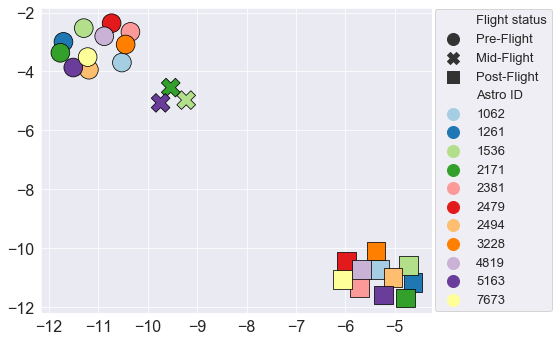

In [889]:
fontsize=16

plt.figure(figsize=(7, 5.6))
embed.rename({'astro id':'Astro ID', 'flight status':'Flight status'}, axis=1, inplace=True)

ax = sns.scatterplot(x='dim1', y='dim2', data=embed, hue='Astro ID', style_order=['Pre-Flight', 'Mid-Flight', 'Post-Flight'],
                     alpha=1, style='Flight status', legend='full',
                     palette=sns.color_palette('Paired', len(embed['Astro ID'].unique())),  
                    **{'s':350, 'linewidths':1, 'edgecolor':'black'})

plt.tick_params(labelsize=fontsize)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('', fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[12:]+handles[0:12], labels[12:]+labels[0:12],
           loc='upper left', bbox_to_anchor=(.99, 1.02),
           fancybox=True, markerscale=2, fontsize=13)

plt.savefig('../MANUSCRIPT 11 ASTROS/figures/11 astros pre post all data UMAP dimensionality reduction.png', 
            dpi=600, bbox_inches='tight')